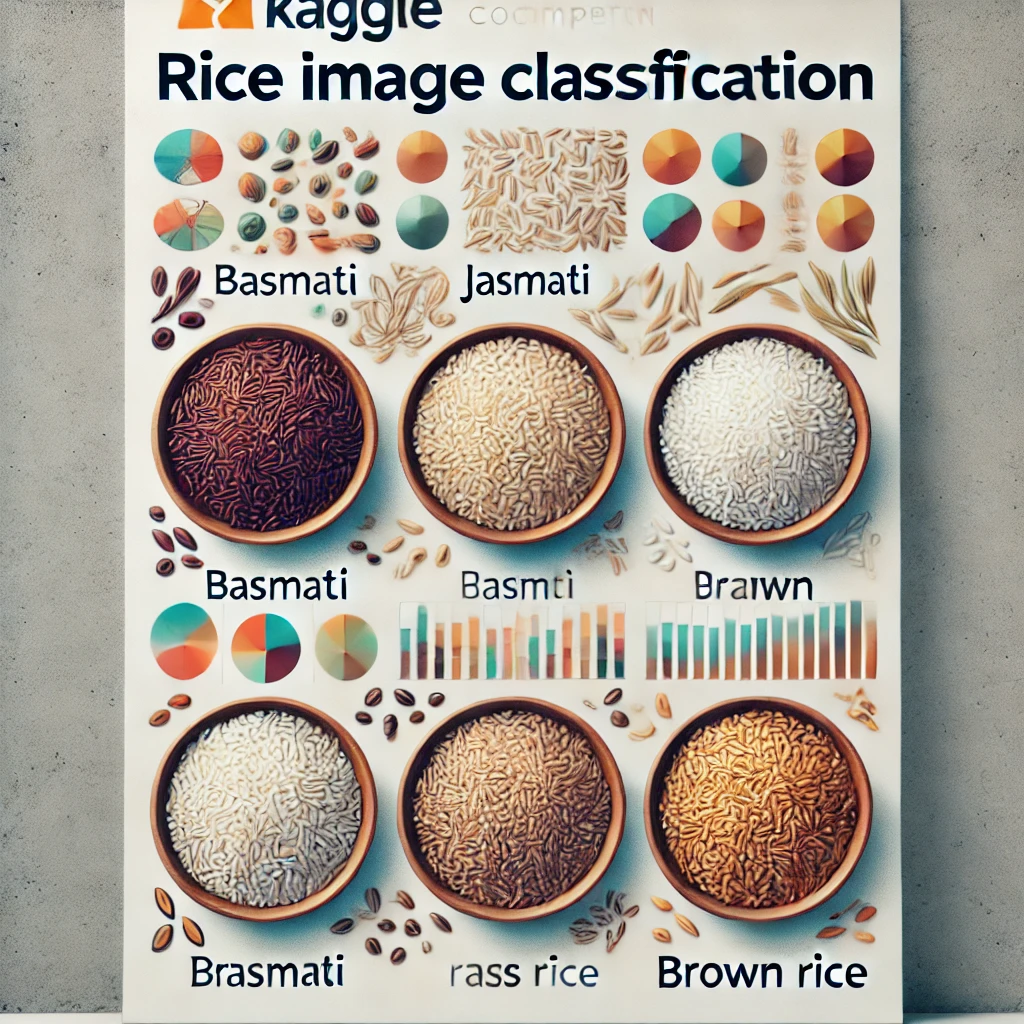

In [1]:
#!pip install plotly
#!pip install --upgrade pip
#!pip install pydot
#!apt-get -y install graphviz
#!pip install pydot graphviz
#!pip install graphviz
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.6 MB/s eta 0:00:0000:010:01


# 1. Introduction

Rice is one of the most widely produced grains globally, with numerous genetic varieties. These varieties differ based on characteristics such as texture, shape, and color. By analyzing these distinguishing features, it is possible to classify rice varieties and assess seed quality.

In this study, five rice varieties commonly grown in Turkey—Arborio, Basmati, Ipsala, Jasmine, and Karacadag—were examined. The dataset includes 75,000 grain images, with 15,000 images from each variety. 

To classify the data, Artificial Neural Network (ANN) and Deep Neural Network (DNN) algorithms were applied to the feature dataset, while the Convolutional Neural Network (CNN) algorithm was used for the image dataset. 

# 2. Project Goal

The goal is to develop a CNN / Tensorflow model that can accurately identify different rice varieties from their images.


# 3. Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import shutil
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action="ignore")
import pydot
import graphviz
import plotly
import random
import torch
import visualkeras
from tensorflow.keras.optimizers import SGD

# 4. Reading dataset

In [3]:
base_dir = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

In [4]:
# List the folder's name of Dataset
folder_names = os.listdir(base_dir)
folder_names

['Karacadag',
 'Basmati',
 'Jasmine',
 'Rice_Citation_Request.txt',
 'Arborio',
 'Ipsala']

In [5]:
# Remove Text File in the Dataset

folder_names.remove('Rice_Citation_Request.txt')
folder_names

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

# 5. Visualization

## 5.1. Plot Different Types of Rice

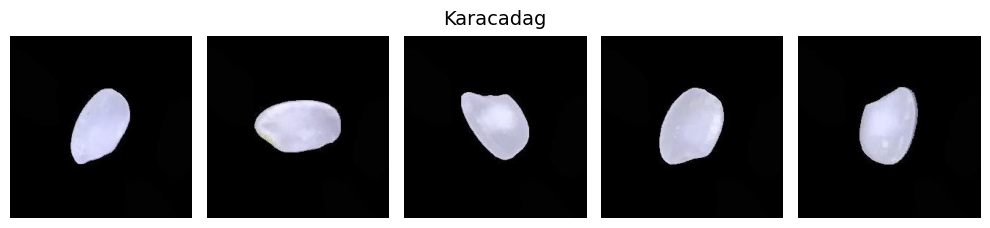

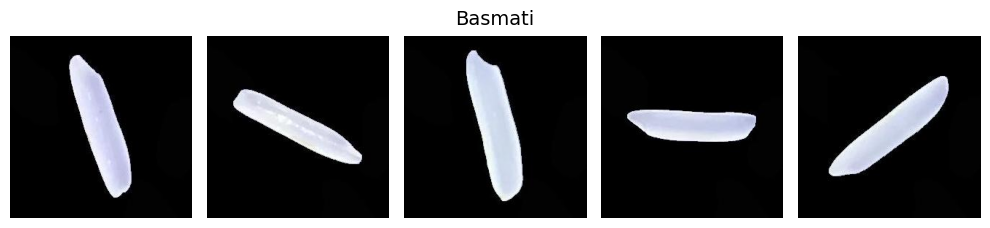

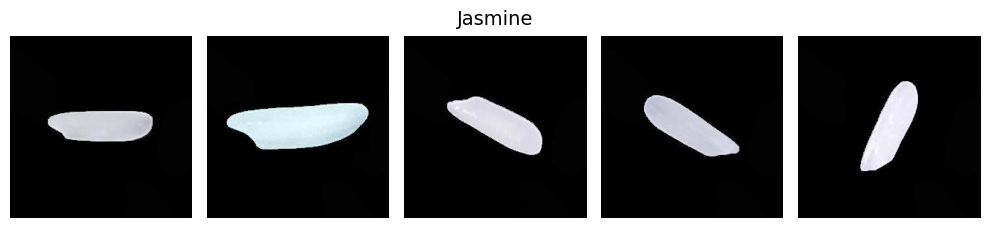

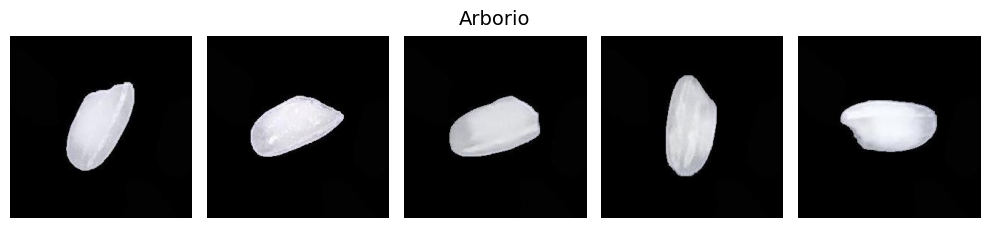

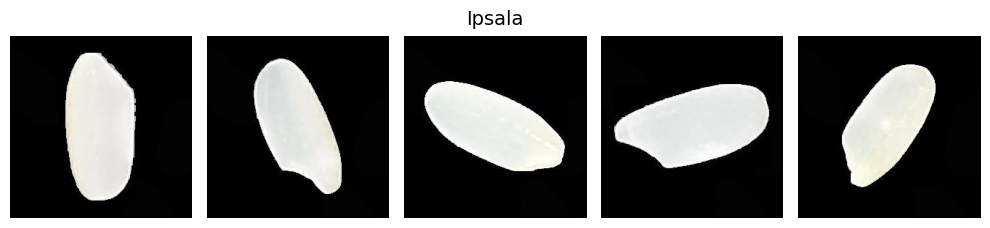

In [6]:
for category in folder_names:
    category_path = os.path.join(base_dir, category)  # Path to the dataset sub-folder 
    
    if os.path.isdir(category_path):                 # Check if it's a folder
        images = os.listdir(category_path)[:5]      # Get the first 5 images in the folder
         
        plt.figure(figsize=(10, 5))
        
        for i, image_file in enumerate(images):
            image_path = os.path.join(category_path, image_file)
            image = Image.open(image_path)
            
            # Add image to the plot
            plt.subplot(1, 5, i + 1)  
            plt.imshow(image)
            plt.axis("off")  # Hide axes

        plt.suptitle(category, fontsize=14, y=0.7)    
        plt.tight_layout()
        plt.show()

## 5.2. Barplot

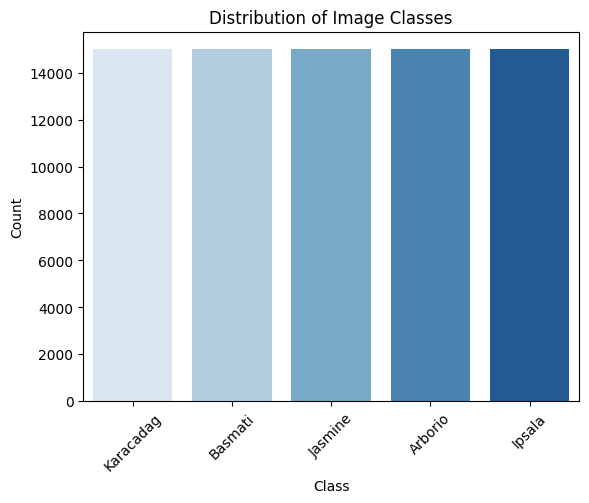

In [7]:

# Create a list of labels for all images
labels = []
for folder in folder_names:
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        num_images = len(os.listdir(folder_path))  # Count images in the folder
        labels.extend([folder] * num_images)  # Add folder name as label for each image

palette = sns.color_palette("Blues", len(folder_names))

# Create the countplot
sns.countplot(x=labels, order=folder_names, palette=palette)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Image Classes')
plt.xticks(rotation=45)
plt.show()

#### Observation:

Looking at the bar plot, it can be seen that the dataset is balanced.

## 5.3. Pie chart

In [8]:
type_count = {}

for folders in folder_names:
    class_path = os.path.join(base_dir, folders)

    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        type_count[folders] = num_images

print(type_count)

{'Karacadag': 15000, 'Basmati': 15000, 'Jasmine': 15000, 'Arborio': 15000, 'Ipsala': 15000}


In [10]:
count = list(type_count.values())
label = list(type_count.keys())

fig = go.Figure(data=[go.Pie(labels=label,
                             values=count,
                             hole=0.5,
                             marker_colors=px.colors.sequential.Blues,
                             textinfo='label+percent',
                             insidetextorientation='radial')])

fig.update_layout(title='Rice Classes Distribution',
                  height=800,  # Corrected typo here
                  width=800,
                  title_x=0.5,  # Center the title
                  font=dict(size=15))  # Adjust font size if needed
fig.show()

# 6. Get the Class Names (Labels)

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels='inferred'
)

class_names = dataset.class_names
print(class_names)

Found 75000 files belonging to 5 classes.
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


# 7. Data Preparation



In this step, data from 5 folders will be combined to create one folder. Then the data will be shuffled to ensure that the same data do not appear consecutively. In the next step , the data will be split into Train, Validation, and Test sets for further analysis. In the end, training data will be normalized. The raw pixel values (0 to 255) have a wide range, which can lead to 
large gradient values during backpropagation, making the training unstable. Normalization: By scaling the pixel values to a smaller range, such as [0, 1] (dividing by 255) or [-1, 1] 
(subtracting the mean and dividing by the standard deviation), the network processes inputs more efficiently.

#### Additional consideration:

For small dataset or simple images: 

We start with dimensions like 64x64 or 128x128 which is suitable for datasets with small objects or basic patterns, e.g., MNIST or CIFAR.

For larger and more complex images:

We use dimensions like 224x224 or 256x256. These sizes align with many pretrained models (e.g., ResNet, VGG).

## 7.1. Convert Images from Folders into Dataframe

In [12]:
image_data = []  

# Iterate through each class in the detection
for class_name in folder_names:
    class_path = os.path.join(base_dir, class_name)  
    if os.path.isdir(class_path):
        files = os.listdir(class_path)  
    
    # Loop through all files and add their paths and class labels to the image_data list
    for file in files:
        file_path = os.path.join(class_path, file)  # Create the full file path
        image_data.append((file_path, class_name))  # Append tuple to the list

df = pd.DataFrame(image_data, columns=['path', 'label'])

df = df.sample(frac=1).reset_index(drop=True)

# Display the first few entries of the DataFrame
display(df.head(10))  # Change from print to display

path      label
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Basmati
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Basmati
5  /kaggle/input/rice-image-dataset/Rice_Image_Da...     Ipsala
6  /kaggle/input/rice-image-dataset/Rice_Image_Da...     Ipsala
7  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Arborio
8  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
9  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Jasmine

#### Explanation: 

##### Now, the dataset has been shuffled and is ready to be split.

##### The dataset consists of 75,000 samples, which have been split as follows:

##### Training set: 60,000 samples
##### Validation set: 15,000 samples
##### Test set: 15,000 samples
##### Below is the process used for splitting the dataset.

## 7.2. Train/ validation/ Test split

In [13]:
train = df[:60000]
validation = df[60000:67500]
test = df[67500:]

train.reset_index(inplace=True, drop=True)
validation.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

print(f'Number of samples in Training: {len(train)}')
print(f'Number of samples in validation: {len(validation)}')
print(f'Number of samples in test: {len(test)}')

Number of samples in Training: 60000
Number of samples in validation: 7500
Number of samples in test: 7500


## 7.3. Check Image Size

In [14]:
image_ = df["path"][3]
image = Image.open(image_)
height, width = image.size
height, width

(250, 250)

## 7.4. Initial Values

In [15]:
batch_size = 16
image_size = (224, 224)
input_shape = (224, 224, 3)

## 7.5. Data Augmentation

##### ImageDataGenerator is a powerful data augmentation and preprocessing tool in Keras, used 

##### to generate batches of image data with real-time augmentation. It helps improve model 

##### generalization by introducing variations in training images.

##### Data Augmentation: Applies random transformations like rotation, zoom, shear, and 

##### flipping. 

##### Normalization: Scales pixel values (e.g., rescaling to [0,1] or standardizing). 

##### Automatic Labeling: Extracts labels from directory structure. Real-Time Processing: 

##### Augments images during training to reduce memory usage.


In [16]:
data_generator = ImageDataGenerator(rescale=1./255)

train_gen = data_generator.flow_from_dataframe(
                  dataframe=train,
                  x_col="path",
                  y_col="label",
                  target_size=image_size,
                  batch_size=batch_size,
                  class_mode="categorical",
                  shuffle=True,
                  seed=42
)

validation_gen = data_generator.flow_from_dataframe(
                  dataframe=validation,
                  x_col="path",
                  y_col="label",
                  target_size=image_size,
                  batch_size=batch_size,
                  class_mode="categorical",
                  shuffle=False,
                  seed=42
)

test_gen = data_generator.flow_from_dataframe(
                  dataframe=test,
                  x_col="path",
                  y_col="label",
                  target_size=image_size,
                  batch_size=batch_size,
                  class_mode="categorical",
                  shuffle=False,
                  seed=42
)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


## 7.6. Get the Class Labels

In [17]:
class_labels = train_gen.class_indices 
print(class_labels.keys())

class_labels = validation_gen.class_indices 
print(class_labels.keys())

class_labels = test_gen.class_indices 
print(class_labels.keys())

dict_keys(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
dict_keys(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
dict_keys(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])


# 8. Model Analysis

#### For this project, three models have been run and analyzed:

##### Model 1: ReLU, Softmax, RMSprop, 20 epochs
##### Model 2: ReLU, Softmax, Adam, 20 epoch 
##### Model 3:LeNet

## 8.1. Model 1: ReLU, Softmax, RMSprop, 20 epochs

#### In a CNN's last dense layer, you should use softmax for multi-class classification 

#### problems, where you want to predict probabilities for multiple possible classes, while 

#### sigmoid is used for binary classification tasks, where you only need to predict the 

#### probability of belonging to one of two classes; essentially, softmax is preferred when 

#### you have more than two possible output classes, while sigmoid is used when you only have 

#### two classes. 

In [18]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape = (224, 224, 3)))
model1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
model1.add(tf.keras.layers.Dense(units = 5, activation = 'softmax'))  

# Compile the model
model1.compile(optimizer= "RMSprop" ,loss='categorical_crossentropy',  metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     201,867,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,871,237 (770.08 MB)

 Trainable params: 201,871,237 (770.08 MB)

 Non-trainable params: 0 (0.00 B)

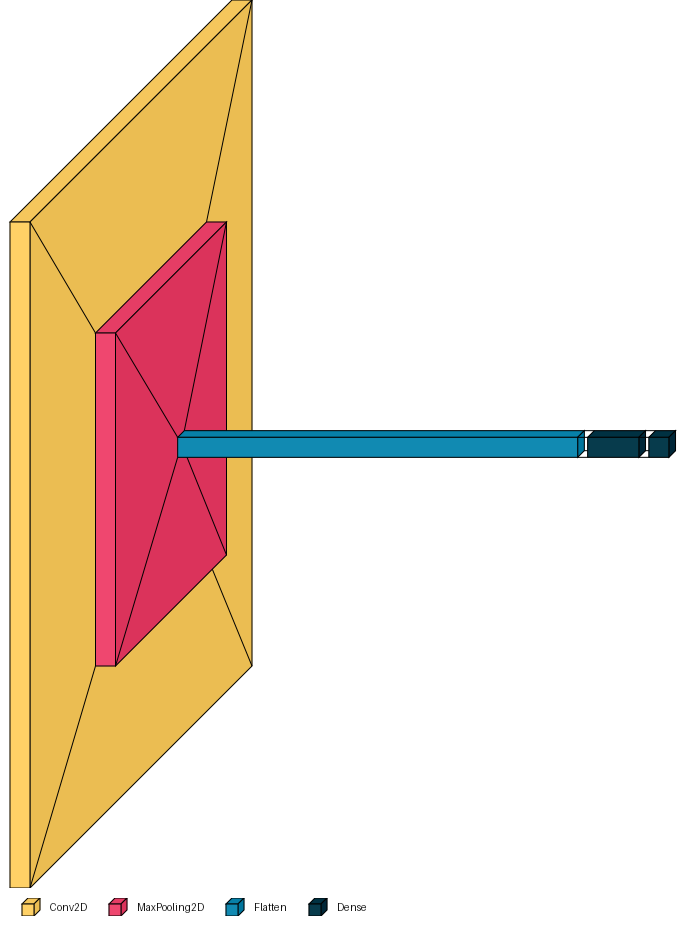

In [19]:
visualkeras.layered_view(model1, scale_xy=3, legend=True)

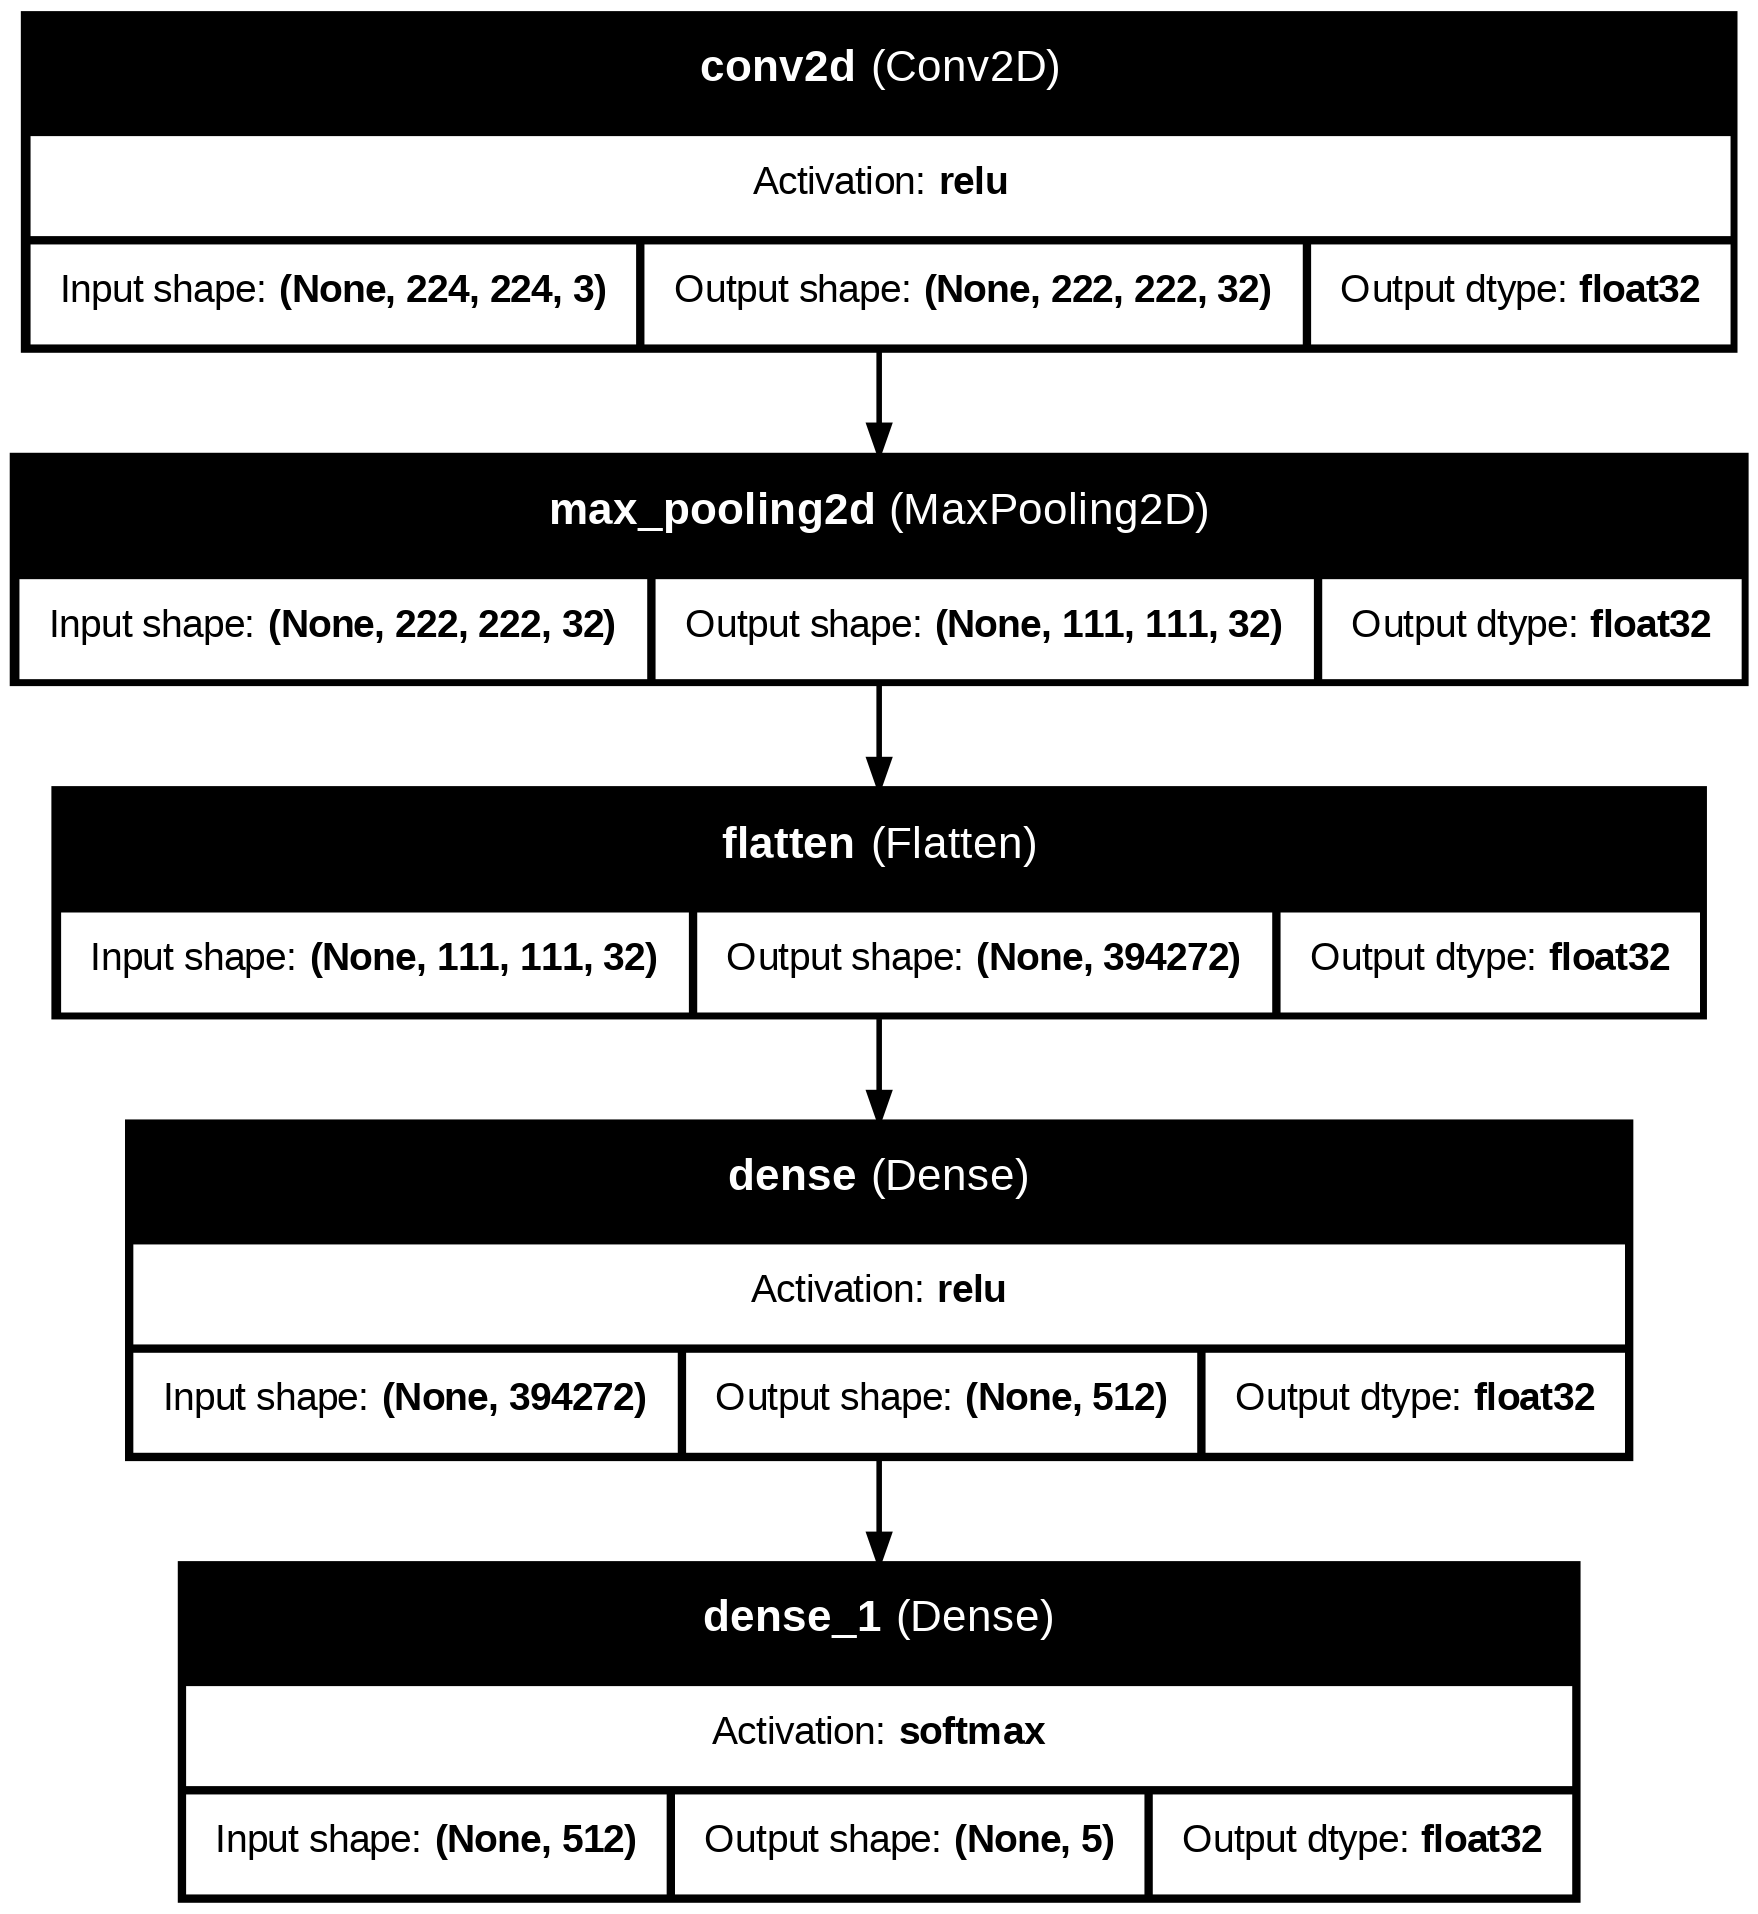

In [20]:
tf.keras.utils.plot_model(
    model1,
    to_file='model1.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    )

#### Till here we just created the model. We have not fed data yet. 

### 8.1.1. Training the CNN

In [21]:
history_model1 = model1.fit(train_gen,validation_data=validation_gen, epochs=20)

Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 355s 93ms/step - accuracy: 0.9301 - loss: 0.5698 - val_accuracy: 0.9819 - val_loss: 0.0581
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 121s 32ms/step - accuracy: 0.9853 - loss: 0.0472 - val_accuracy: 0.9880 - val_loss: 0.0488
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 122s 33ms/step - accuracy: 0.9896 - loss: 0.0310 - val_accuracy: 0.9900 - val_loss: 0.0363
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 33ms/step - accuracy: 0.9926 - loss: 0.0241 - val_accuracy: 0.9876 - val_loss: 0.0758
Epoch 5/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 118s 31ms/step - accuracy: 0.9957 - loss: 0.0167 - val_accuracy: 0.9840 - val_loss: 0.0739
Epoch 6/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 119s 32ms/step - accuracy: 0.9967 - loss: 0.0115 - val_accuracy: 0.9911 - val_loss: 0.0686
Epoch 7/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 117s 31ms/step - accuracy: 0.9976 - loss: 0.0088 - val_accuracy: 0.9893 - val_loss: 0.0745
Epoch 8/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 118s 31ms/step - accuracy: 

In [22]:
df1 = pd.DataFrame(history_model1.history)
df1.head()

accuracy      loss  val_accuracy  val_loss
0  0.962867  0.163702      0.981867  0.058149
1  0.985783  0.046500      0.988000  0.048803
2  0.989883  0.031384      0.990000  0.036336
3  0.993217  0.023117      0.987600  0.075833
4  0.995000  0.018383      0.984000  0.073894

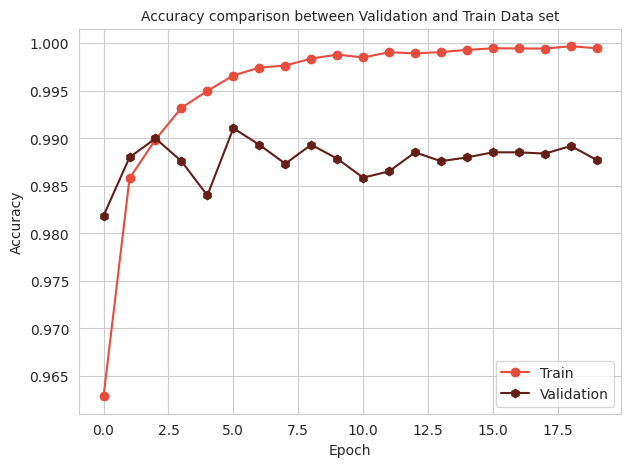

In [23]:
plt.figure(figsize=(7,5))
sb.set_style("whitegrid")
plt.plot(history_model1.history['accuracy'],color="#E74C3C",marker='o')
plt.plot(history_model1.history['val_accuracy'],color='#641E16',marker='h')
plt.title('Accuracy comparison between Validation and Train Data set',fontsize=10)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

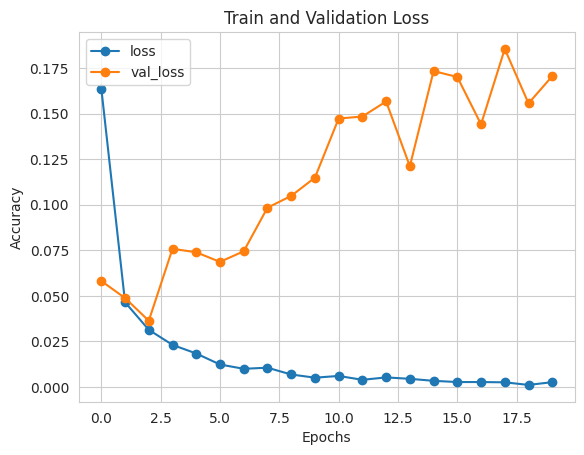

In [24]:
ax = df1[['loss','val_loss']].plot(title = "Train and Validation Loss", marker='o')
ax.set(xlabel ="Epochs", ylabel = "Accuracy")
plt.show()

### Observation

The training accuracy is high, which is expected because machine learning models are designed to learn the patterns in the training data. They adjust their internal settings to minimize errors on that specific data. Essentially, they are optimized to perform well on the data they were trained on.

The Validation accuracy is also high because the images are of high quality and there are no other objects except rice in the pictures. This makes it easier for the CNN to identify the type of rice.

### 8.1.2. Predict the Test Set

In [25]:
y_true = test_gen.classes
y_pred = model1.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step


### 8.1.3. Test Set Accuracy

In [26]:
# Evaluate model on test data
test_loss, test_accuracy = model1.evaluate(test_gen, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9870 - loss: 0.1790
Test Accuracy: 98.59%


### 8.1.4. Actual vs Predicted Images

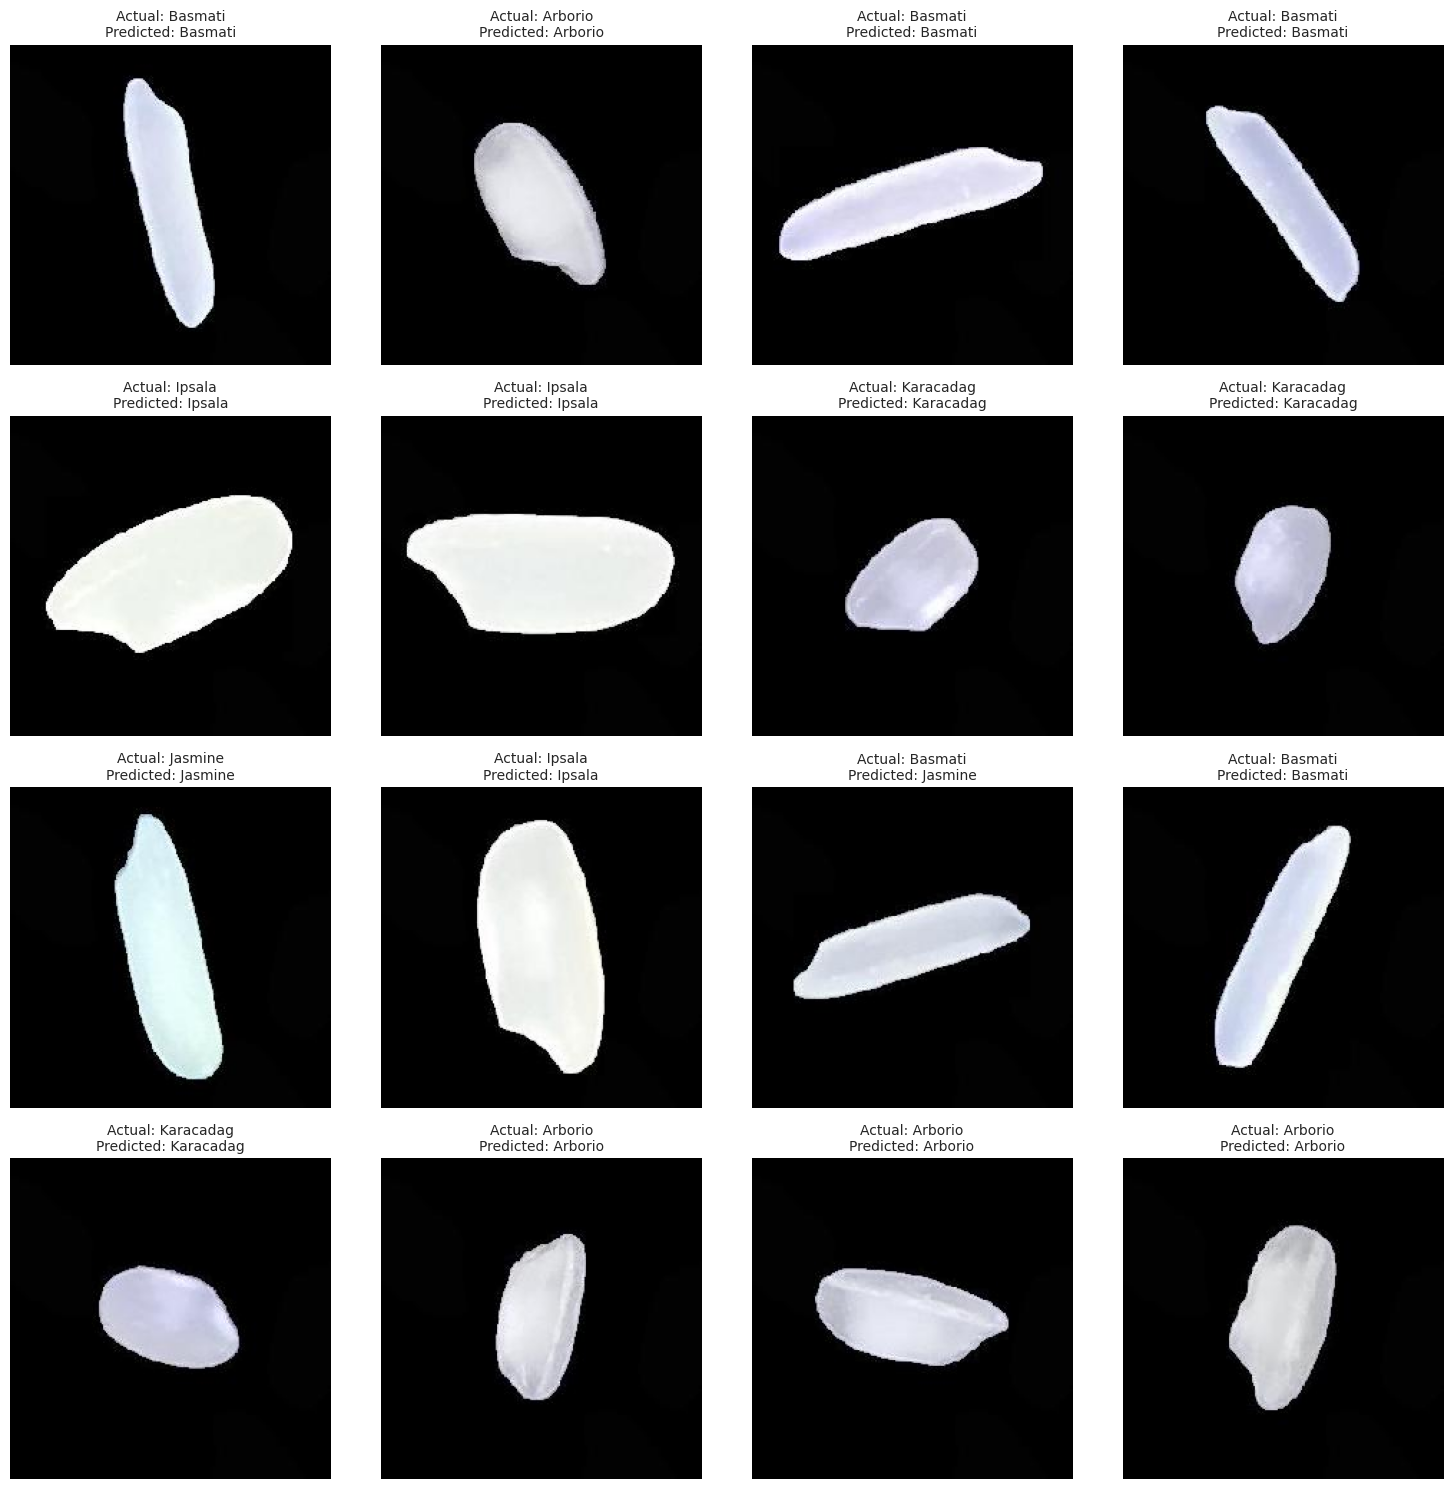

In [27]:
# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Load a batch of test images
test_images, _ = next(test_gen)  # Get images from test generator

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()  # Convert 2D array into a simple list


for i in range(16):  
    axes[i].imshow(test_images[i])  
    
    # Get actual and predicted labels
    actual_label = class_labels[y_true[i]]
    predicted_label = class_labels[y_pred[i]]
    
   
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    
    axes[i].axis("off")  

plt.tight_layout()
plt.show()

### 8.1.5. Confusion Matrix

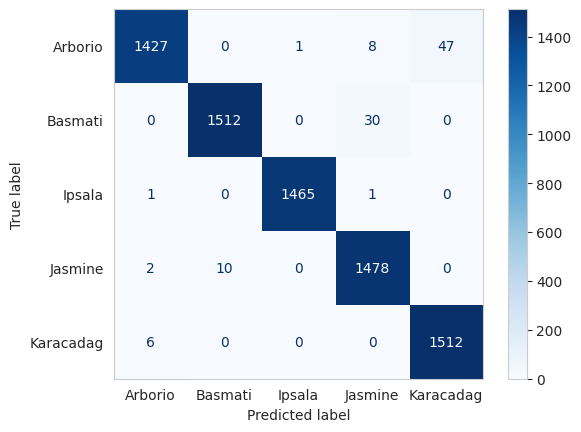

In [28]:
cm1 = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=test_gen.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

### 8.1.6. Classification Report

In [29]:
class_labels = list(test_gen.class_indices.keys())  # Get class labels
report = classification_report(y_true, y_pred, target_names=class_labels)

# Print the classification report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Arborio       0.99      0.96      0.98      1483
     Basmati       0.99      0.98      0.99      1542
      Ipsala       1.00      1.00      1.00      1467
     Jasmine       0.97      0.99      0.98      1490
   Karacadag       0.97      1.00      0.98      1518

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500



## 8.2. Model2: Relu, Softmax, Adam, 20 epochs

In [30]:
model2 = Sequential()

# Convolutional layers

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape = (224, 224, 3)))  
model2.add(BatchNormalization())  
model2.add(MaxPooling2D((2, 2))) 

model2.add(Conv2D(64, (3, 3), activation='relu'))  
model2.add(BatchNormalization())  
model2.add(MaxPooling2D((2, 2)))  


model2.add(Flatten())  # Converts the 2D matrix to a 1D vector
model2.add(Dense(512, activation='relu'))  # Fully connected layer with 512 units
model2.add(Dropout(0.5))  # Dropout layer for regularization

# model2.add(Dense(64, activation='relu'))  # Another dense layer with 64 units
# model2.add(Dropout(0.5))  # Another dropout layer

model2.add(Dense(5, activation='softmax'))  # Output layer for the number of classes

# Compile the model2
model2.compile(optimizer= "adam" ,loss='categorical_crossentropy',  metrics=['accuracy'])


model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      95,552,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,574,341 (364.59 MB)

 Trainable params: 95,574,149 (364.59 MB)

 Non-trainable params: 192 (768.00 B)

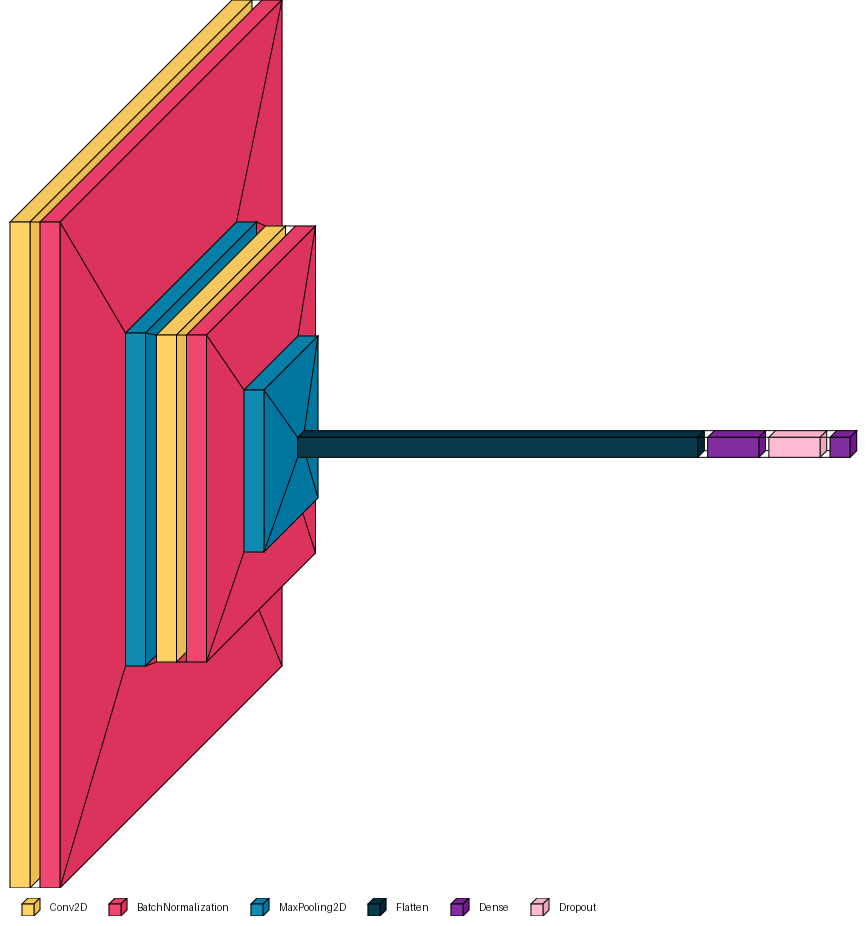

In [32]:
visualkeras.layered_view(model2, scale_xy=3, legend=True)

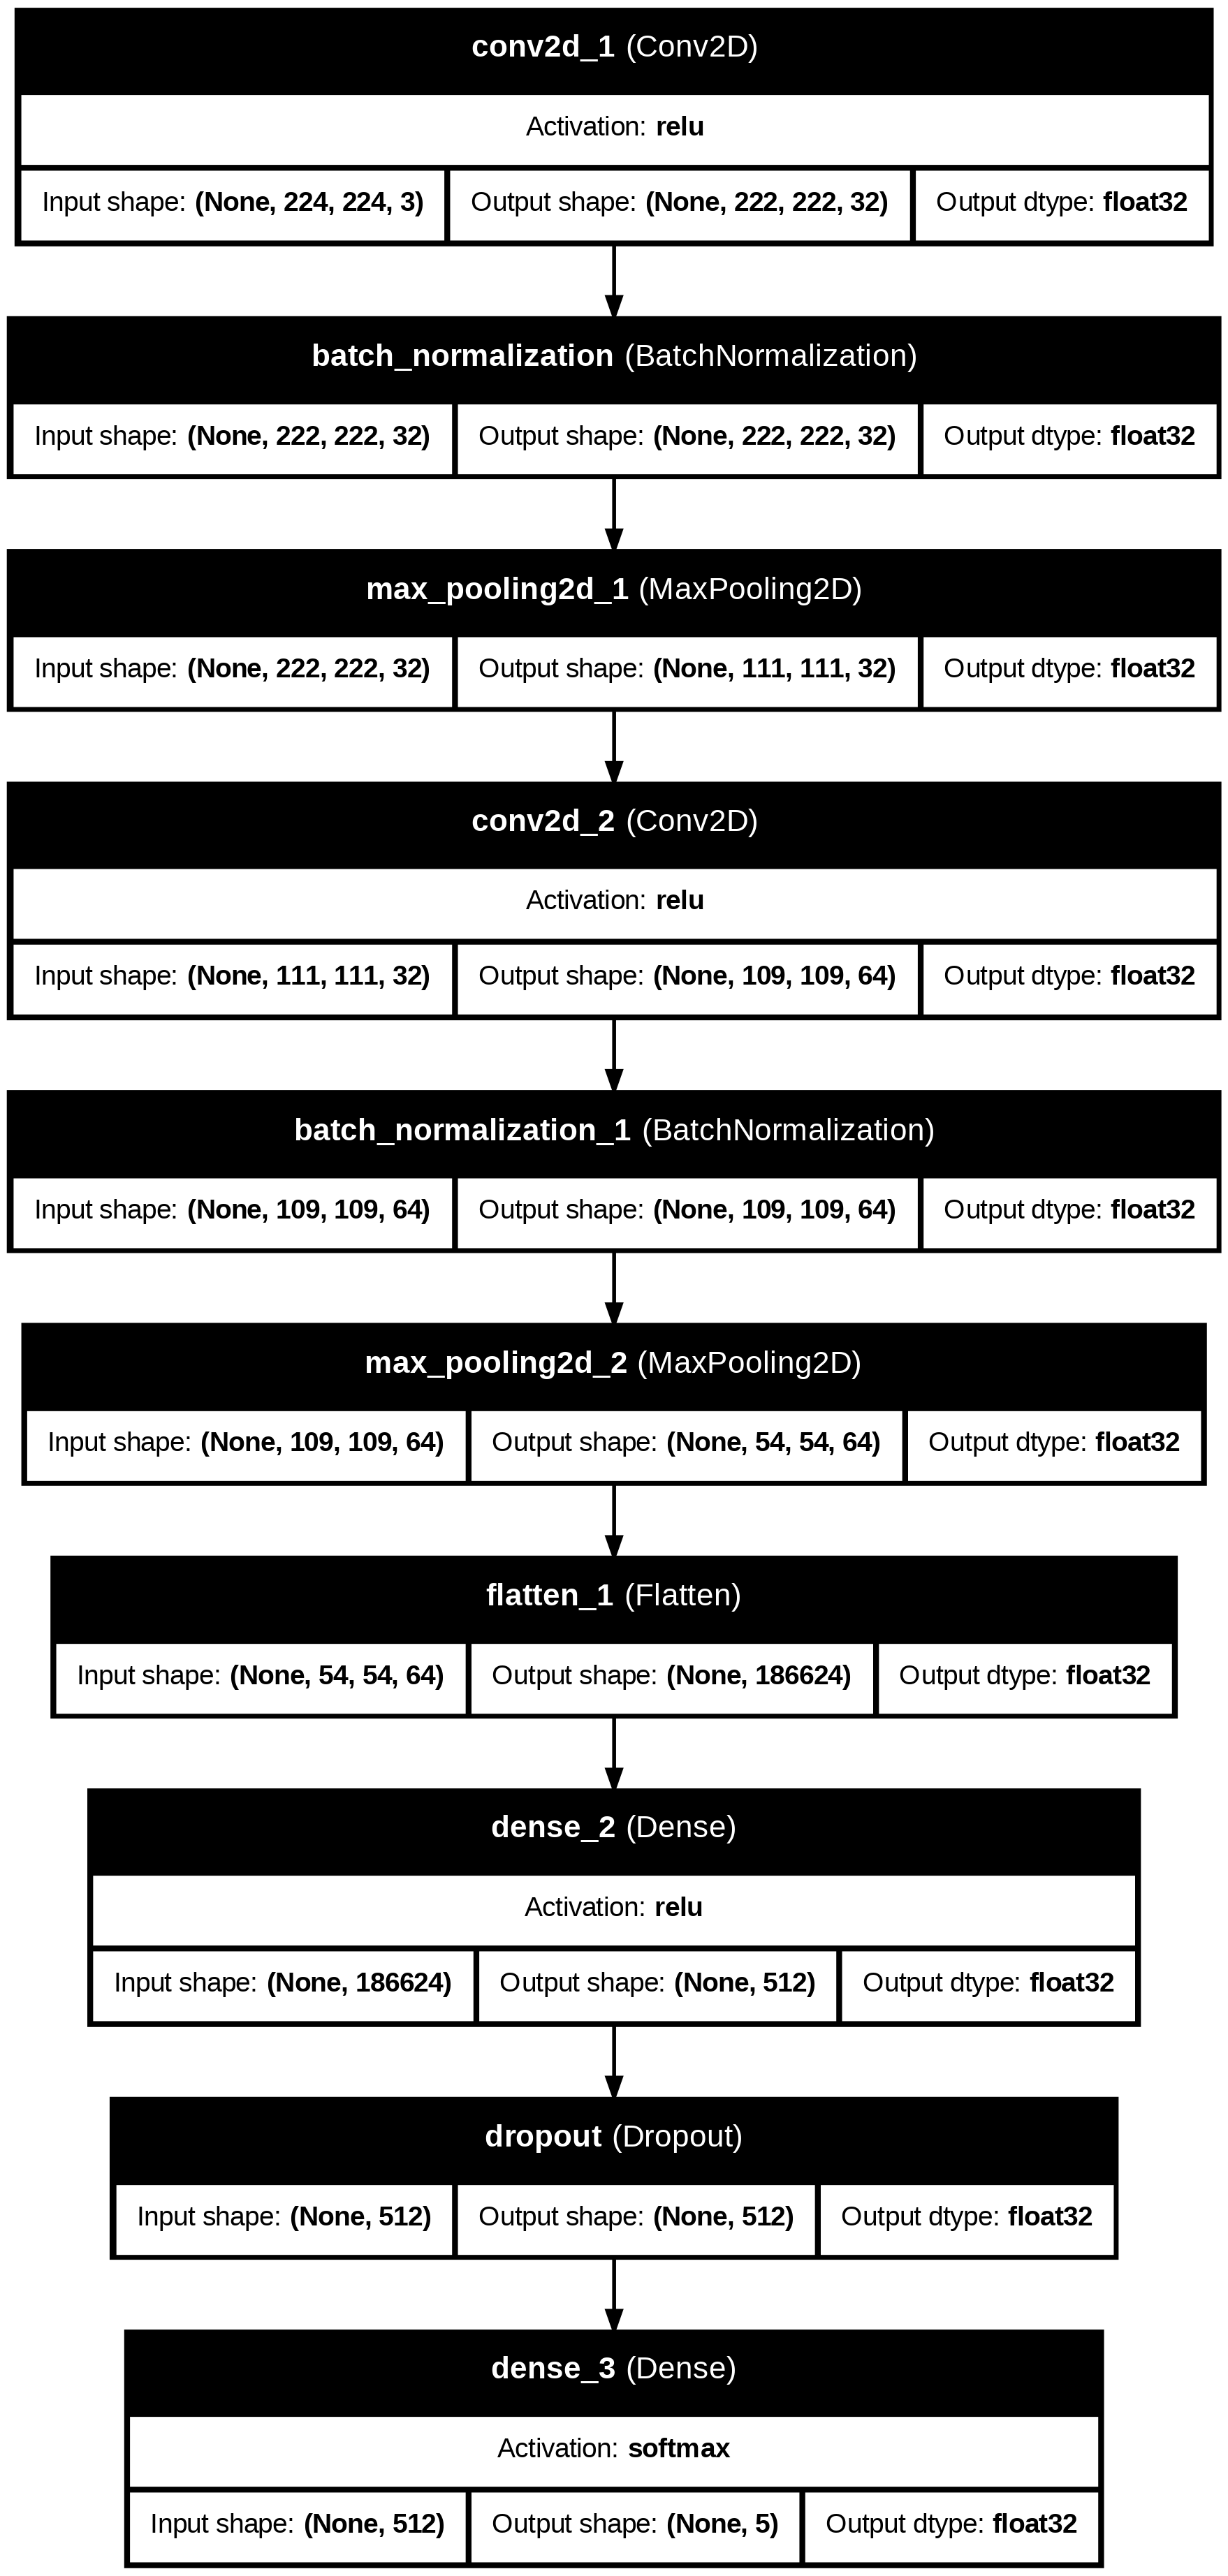

In [31]:
tf.keras.utils.plot_model(
    model2,
    to_file='model2.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    )

### 8.2.1. Training the CNN

In [33]:
history_model2 = model2.fit(train_gen,validation_data=validation_gen, epochs=20)

Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 31ms/step - accuracy: 0.8770 - loss: 5.0018 - val_accuracy: 0.9471 - val_loss: 0.2642
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 107s 28ms/step - accuracy: 0.9353 - loss: 0.3171 - val_accuracy: 0.9700 - val_loss: 0.0987
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 117s 31ms/step - accuracy: 0.9484 - loss: 0.1960 - val_accuracy: 0.9767 - val_loss: 0.1064
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 111s 30ms/step - accuracy: 0.9605 - loss: 0.1569 - val_accuracy: 0.9456 - val_loss: 0.5782
Epoch 5/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 112s 30ms/step - accuracy: 0.9709 - loss: 0.1116 - val_accuracy: 0.9500 - val_loss: 0.1489
Epoch 6/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 30ms/step - accuracy: 0.9802 - loss: 0.0756 - val_accuracy: 0.9863 - val_loss: 0.0519
Epoch 7/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 110s 29ms/step - accuracy: 0.9795 - loss: 0.0880 - val_accuracy: 0.9041 - val_loss: 0.9246
Epoch 8/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 119s 32ms/step - accuracy: 

In [34]:
df2 = pd.DataFrame(history_model2.history)
df2.head()

accuracy      loss  val_accuracy  val_loss
0  0.909183  1.695343      0.947067  0.264244
1  0.934733  0.292641      0.970000  0.098730
2  0.955183  0.165144      0.976667  0.106401
3  0.961100  0.150969      0.945600  0.578227
4  0.968000  0.122936      0.950000  0.148924

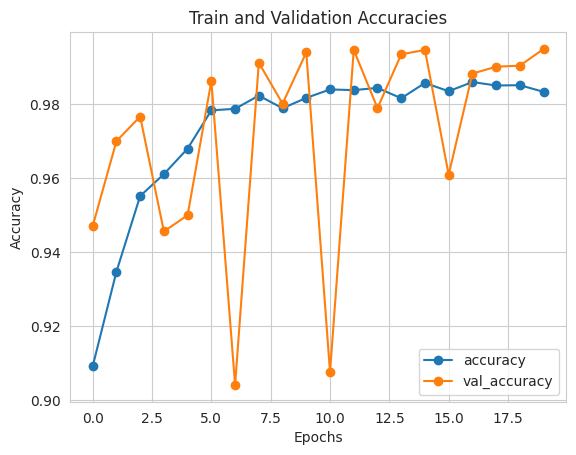

In [35]:
ax = df2[['accuracy','val_accuracy']].plot(title = "Train and Validation Accuracies" , marker='o')
ax.set(xlabel ="Epochs", ylabel = "Accuracy")
plt.show()

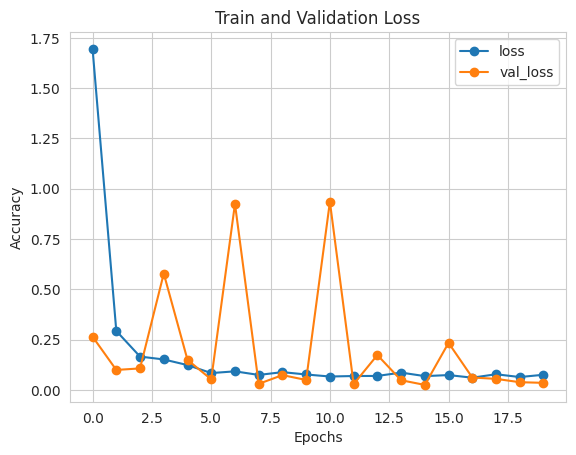

In [36]:
ax = df2[['loss','val_loss']].plot(title = "Train and Validation Loss", marker='o')
ax.set(xlabel ="Epochs", ylabel = "Accuracy")
plt.show()

### 8.2.2. Predict the Test Set

In [37]:
y_true = test_gen.classes
y_pred_model2 = model2.predict(test_gen)
y_pred_model2 = np.argmax(y_pred_model2, axis=1)

469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step


### 8.2.3. Test Set Accuracy

In [38]:
test_loss, test_accuracy = model2.evaluate(test_gen, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9921 - loss: 0.0450
Test Accuracy: 99.20%


### 8.2.4. Actual vs Predicted Images

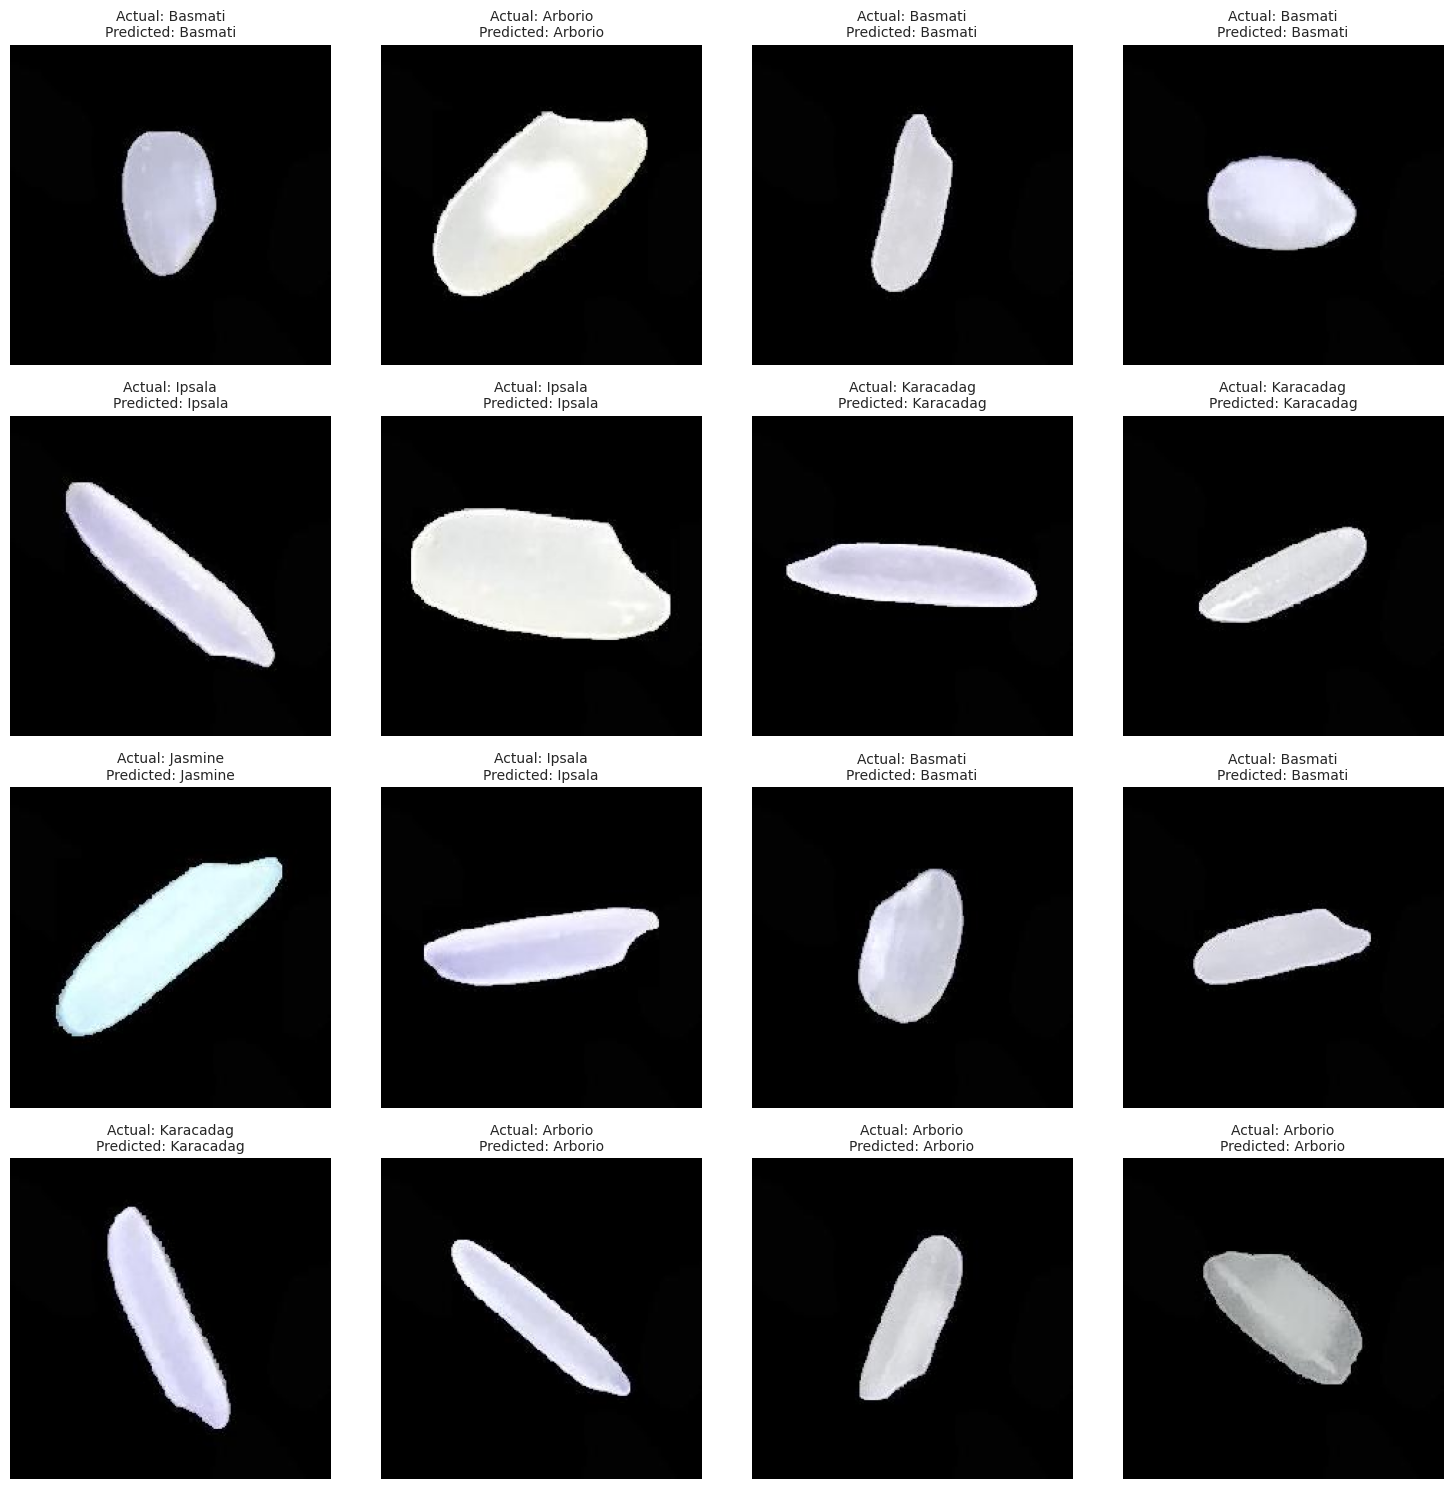

In [39]:
# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Load a batch of test images
test_images, _ = next(test_gen)  # Get images from test generator

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()  # Convert 2D array into a simple list


for i in range(16):  
    axes[i].imshow(test_images[i])  
    
    # Get actual and predicted labels
    actual_label = class_labels[y_true[i]]
    predicted_label = class_labels[y_pred_model2[i]]
    
   
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    
    axes[i].axis("off")  

plt.tight_layout()
plt.show()

### 8.2.5. Confusion Matrix

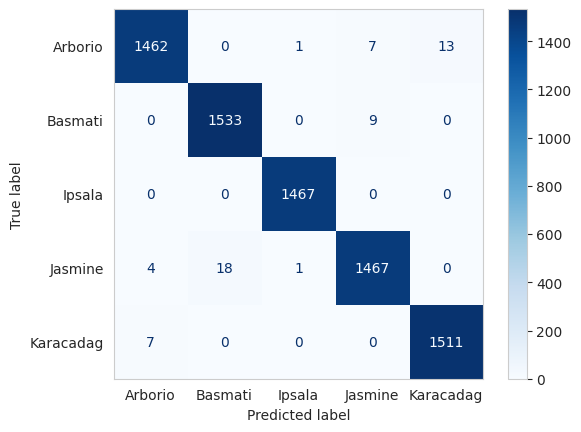

In [40]:
cm2 = confusion_matrix(y_true, y_pred_model2)

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=test_gen.class_indices.keys())
disp2.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

### 8.2.6. Classification Report

In [41]:
class_labels = list(test_gen.class_indices.keys())  # Get class labels
report2 = classification_report(y_true, y_pred_model2, target_names=class_labels)

# Print the classification report
print("Classification Report:\n")
print(report2)

Classification Report:

              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      1483
     Basmati       0.99      0.99      0.99      1542
      Ipsala       1.00      1.00      1.00      1467
     Jasmine       0.99      0.98      0.99      1490
   Karacadag       0.99      1.00      0.99      1518

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500



## 8.3. Model3: LeNet Model Architecture

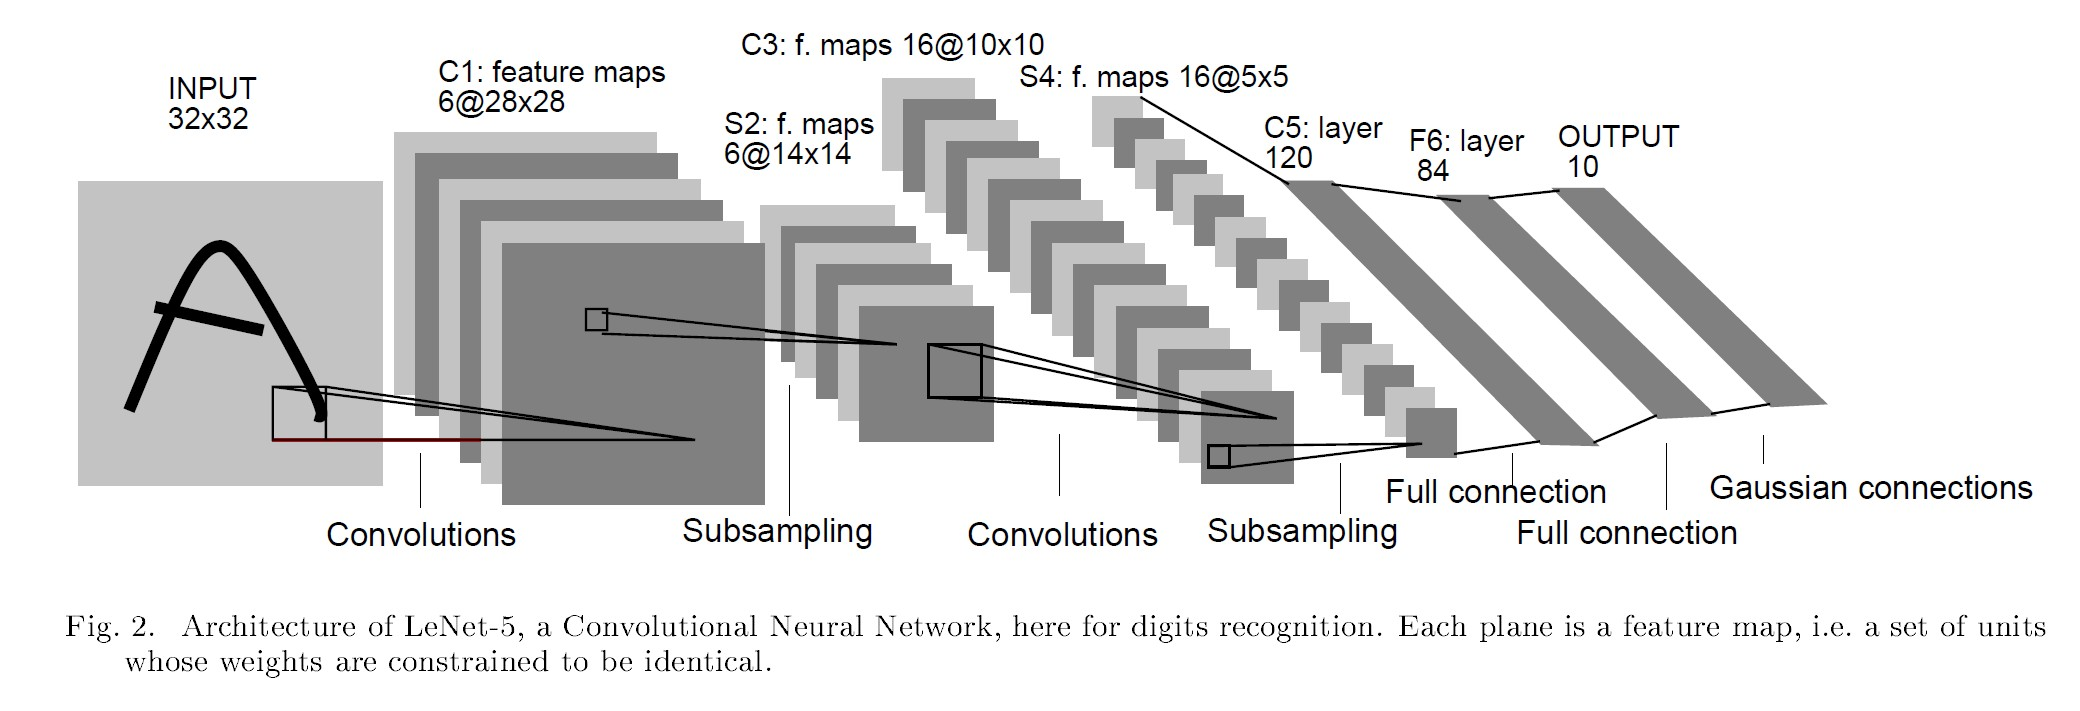

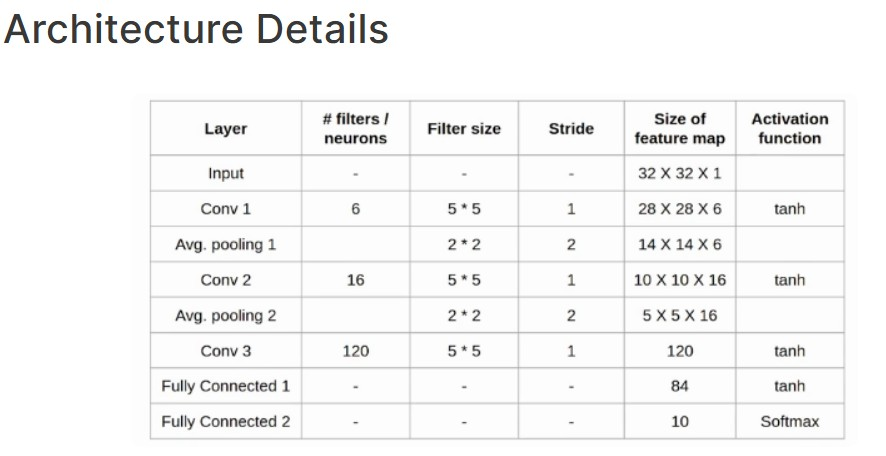

In [42]:
model3 = Sequential()
model3.add(tf.keras.layers.Conv2D(filters=6, strides=(1,1), kernel_size=(5,5), activation='tanh', input_shape=input_shape))
model3.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(tf.keras.layers.Conv2D(filters=16, strides=(1,1), kernel_size=(5,5), activation='tanh'))  # Change filters to 16
model3.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(tf.keras.layers.Dense(units=120, activation='tanh'))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(units=84, activation='tanh'))
model3.add(tf.keras.layers.Dense(units=5, activation='softmax'))  # Change units to 10 for 10 classes
optimizer = SGD(learning_rate=0.1, momentum=0.0, decay=0.0)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 53, 53, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 53, 53, 120)         │           2,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 337080)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 84)                  │      28,314,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,320,141 (108.03 MB)

 Trainable params: 28,320,141 (108.03 MB)

 Non-trainable params: 0 (0.00 B)

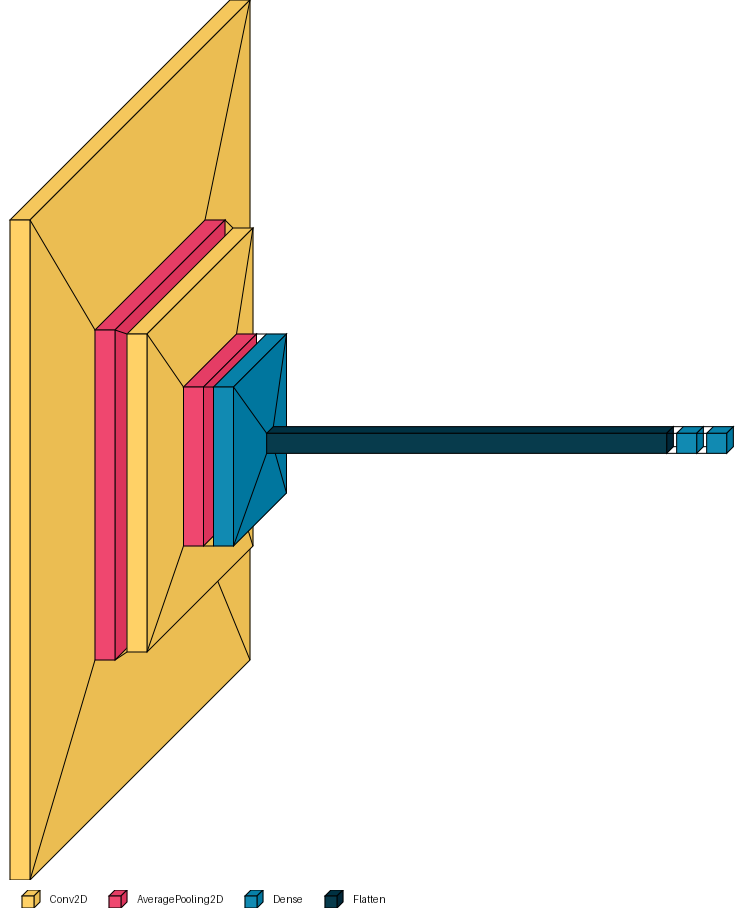

In [43]:
visualkeras.layered_view(model3, scale_xy=3, legend=True)

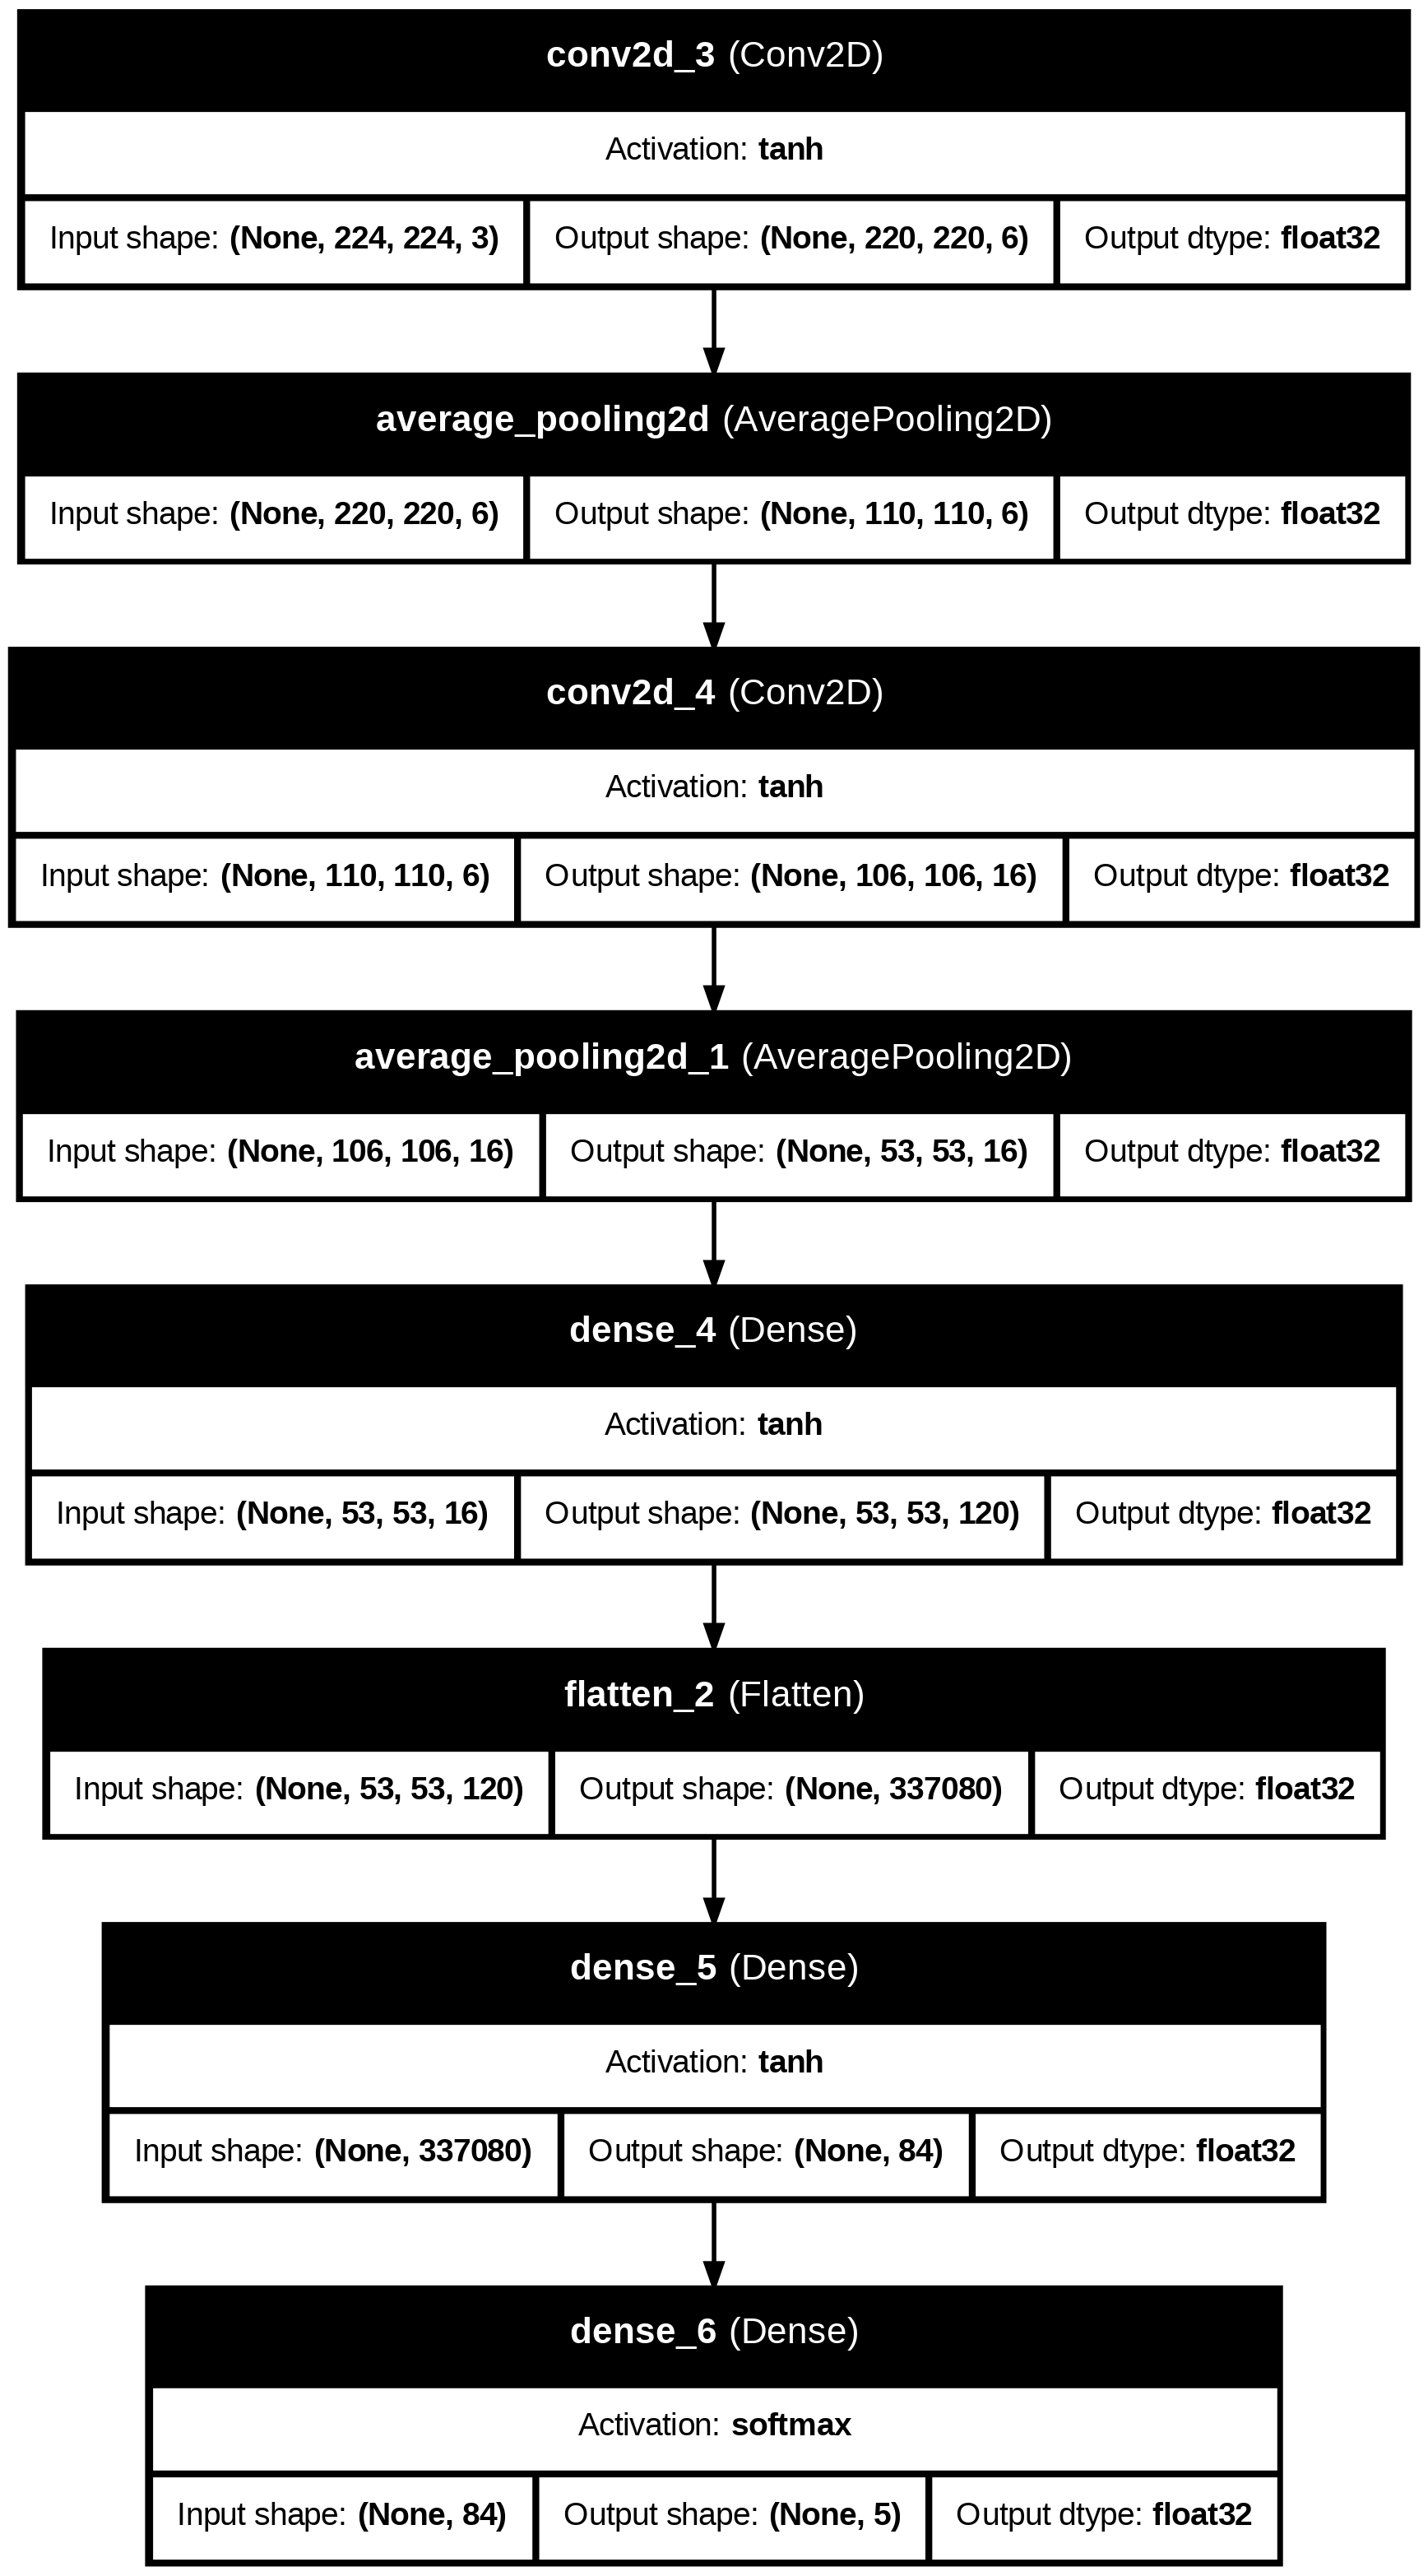

In [44]:
tf.keras.utils.plot_model(
    model3,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    )

### 8.3.1. Training the CNN

In [45]:
history_model3 = model3.fit(train_gen,validation_data=validation_gen, epochs=20)

Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 116s 30ms/step - accuracy: 0.3630 - loss: 1.6888 - val_accuracy: 0.3992 - val_loss: 1.2823
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.3257 - loss: 1.7715 - val_accuracy: 0.2116 - val_loss: 2.3658
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.1989 - loss: 2.1937 - val_accuracy: 0.1957 - val_loss: 1.6639
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 0.2017 - loss: 2.1626 - val_accuracy: 0.2057 - val_loss: 1.8228
Epoch 5/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 110s 29ms/step - accuracy: 0.1984 - loss: 2.2126 - val_accuracy: 0.1971 - val_loss: 2.6220
Epoch 6/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 113s 30ms/step - accuracy: 0.1996 - loss: 2.1862 - val_accuracy: 0.2057 - val_loss: 1.8190
Epoch 7/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 122s 32ms/step - accuracy: 0.2029 - loss: 2.1484 - val_accuracy: 0.2057 - val_loss: 2.0738
Epoch 8/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 

In [46]:
df3 = pd.DataFrame(history_model3.history)
df3.head()

accuracy      loss  val_accuracy  val_loss
0  0.318667  1.817150      0.399200  1.282346
1  0.321100  1.790373      0.211600  2.365845
2  0.201083  2.169972      0.195733  1.663942
3  0.202300  2.161339      0.205733  1.822780
4  0.197067  2.209326      0.197067  2.622009

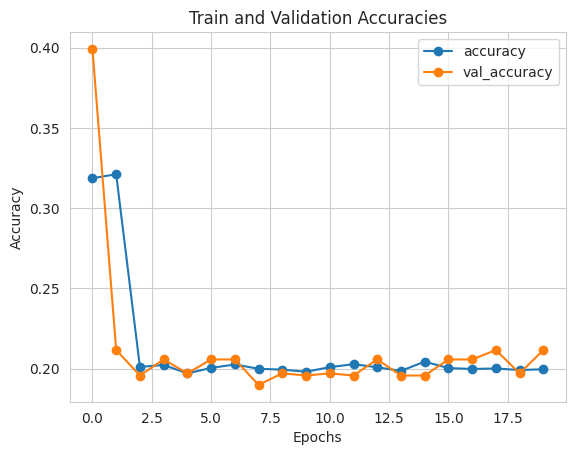

In [47]:
ax = df3[['accuracy','val_accuracy']].plot(title = "Train and Validation Accuracies" , marker='o')
ax.set(xlabel ="Epochs", ylabel = "Accuracy")
plt.show()

### 8.3.2. Predict the Test Set

In [48]:
y_true = test_gen.classes
y_pred_model3 = model3.predict(test_gen)
y_pred_model3 = np.argmax(y_pred_model3, axis=1)

469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step


### 8.3.3. Test Set Accuracy

In [49]:
test_loss, test_accuracy = model3.evaluate(test_gen, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.1973 - loss: 2.0275
Test Accuracy: 19.56%


### 8.3.4. Actual vs Predicted Images

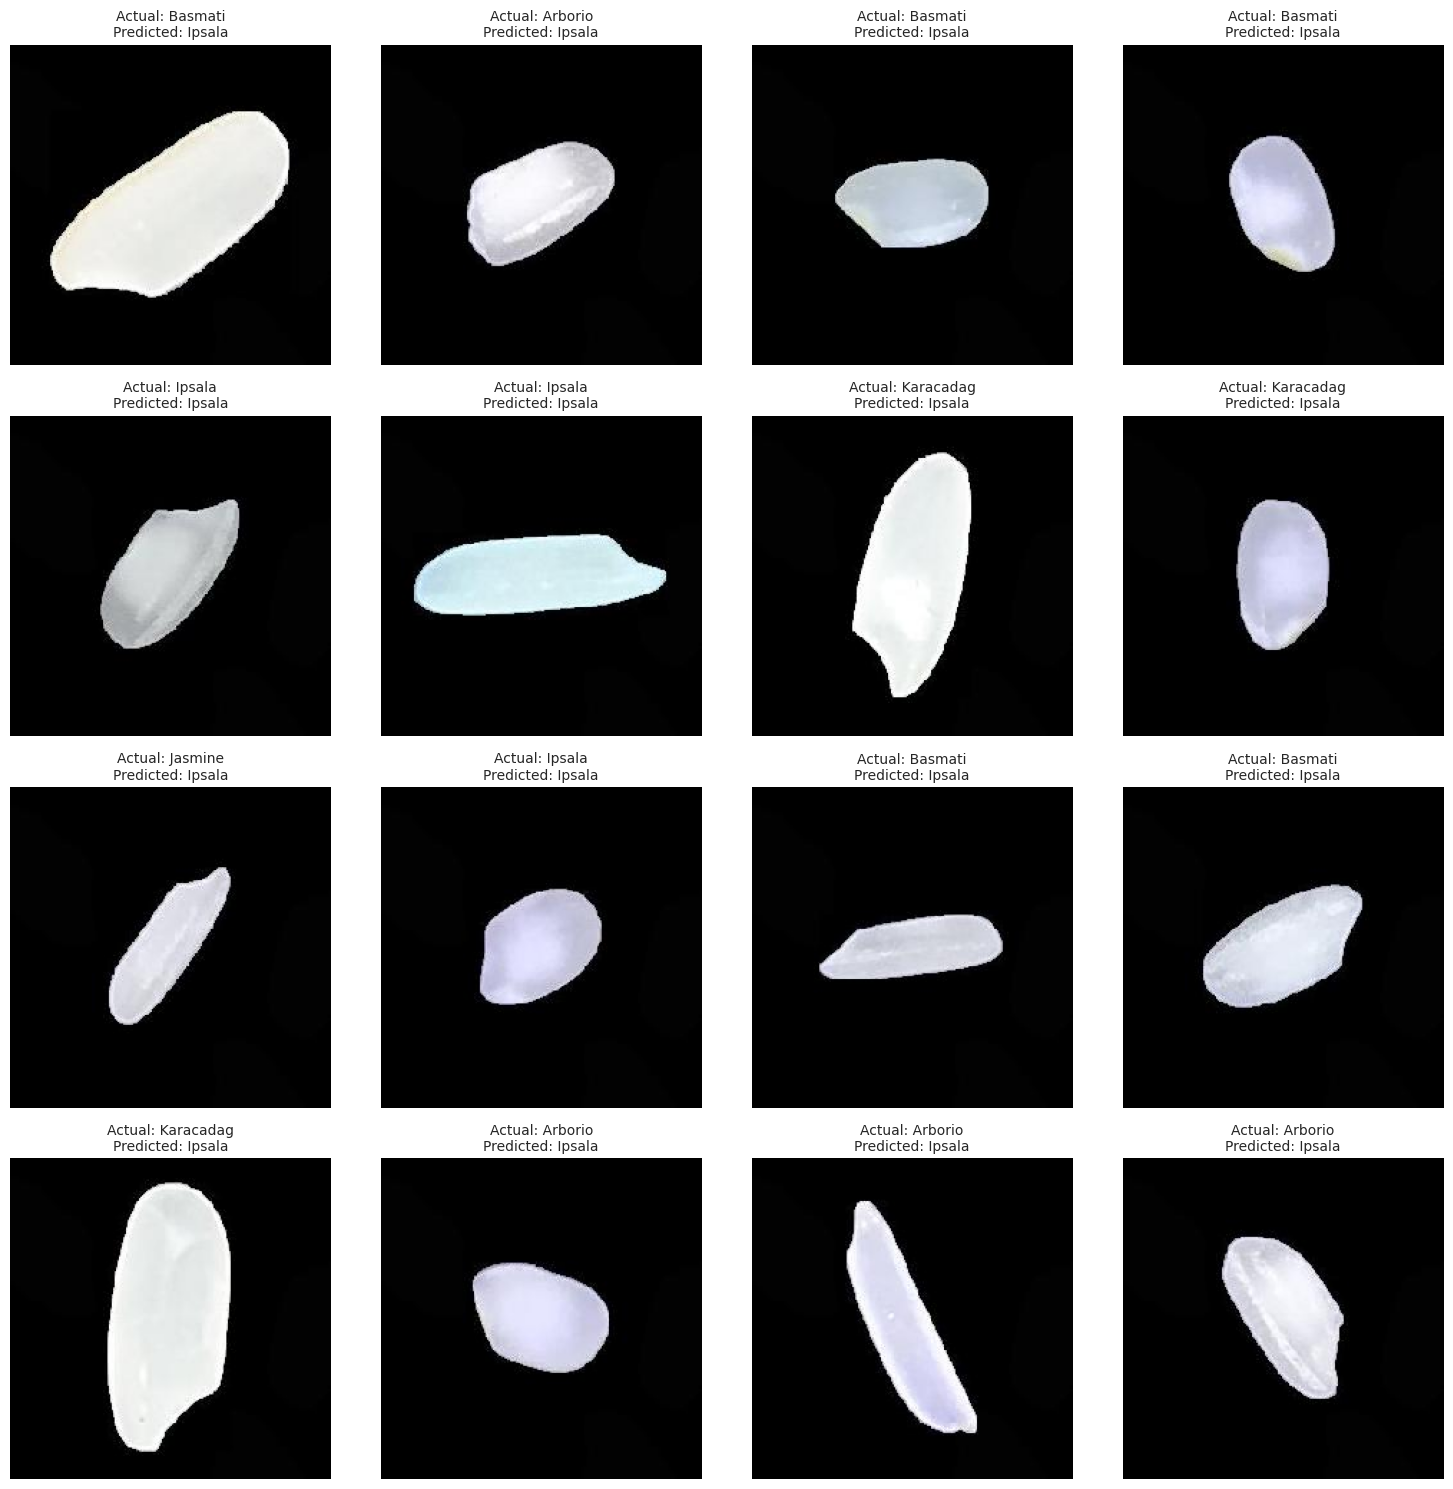

In [50]:
# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Load a batch of test images
test_images, _ = next(test_gen)  # Get images from test generator

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()  # Convert 2D array into a simple list


for i in range(16):  
    axes[i].imshow(test_images[i])  
    
    # Get actual and predicted labels
    actual_label = class_labels[y_true[i]]
    predicted_label = class_labels[y_pred_model3[i]]
    
   
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    
    axes[i].axis("off")  

plt.tight_layout()
plt.show()

### 8.3.5. Confusion Matrix

In [51]:
cm3 = confusion_matrix(y_true, y_pred_model3)

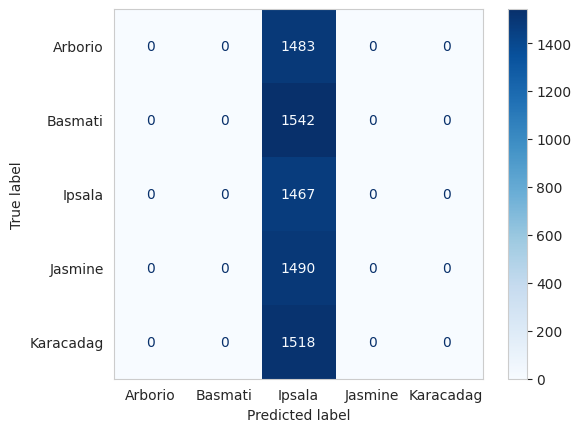

In [52]:
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=test_gen.class_indices.keys())
disp4.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

### 8.3.6. Classification Report

In [53]:
class_labels = list(test_gen.class_indices.keys())  # Get class labels
report3 = classification_report(y_true, y_pred_model3, target_names=class_labels)

# Print the classification report
print("Classification Report:\n")
print(report3)

Classification Report:

              precision    recall  f1-score   support

     Arborio       0.00      0.00      0.00      1483
     Basmati       0.00      0.00      0.00      1542
      Ipsala       0.20      1.00      0.33      1467
     Jasmine       0.00      0.00      0.00      1490
   Karacadag       0.00      0.00      0.00      1518

    accuracy                           0.20      7500
   macro avg       0.04      0.20      0.07      7500
weighted avg       0.04      0.20      0.06      7500



# 9. Models Comparison

In [55]:
def result(Model1, History1, Model2, History2, Model3, History3):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # Create 2x2 grid
    
    # Plot training accuracy
    axs[0, 0].plot(df1['accuracy'], label='Model 1', color='green')
    axs[0, 0].plot(df2['accuracy'], label='Model 2', color='blue')
    axs[0, 0].plot(df3['accuracy'], label='Model 3', color='red')
    axs[0, 0].set_title("Train Accuracy Comparison")
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].legend()

    # Plot validation accuracy
    axs[0, 1].plot(df1['val_accuracy'], label='Model 1', color='green')
    axs[0, 1].plot(df2['val_accuracy'], label='Model 2', color='blue')
    axs[0, 1].plot(df3['val_accuracy'], label='Model 3', color='red')
    axs[0, 1].set_title("Validation Accuracy Comparison")
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].legend()

    # Plot training loss
    axs[1, 0].plot(df1['loss'], label='Model 1', color='green')
    axs[1, 0].plot(df2['loss'], label='Model 2', color='blue')
    axs[1, 0].plot(df3['loss'], label='Model 3', color='red')
    axs[1, 0].set_title("Train Loss Comparison")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].legend()

    # Plot validation loss
    axs[1, 1].plot(df1['val_loss'], label='Model 1', color='green')
    axs[1, 1].plot(df2['val_loss'], label='Model 2', color='blue')
    axs[1, 1].plot(df3['val_loss'], label='Model 3', color='red')
    axs[1, 1].set_title("Validation Loss Comparison")
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

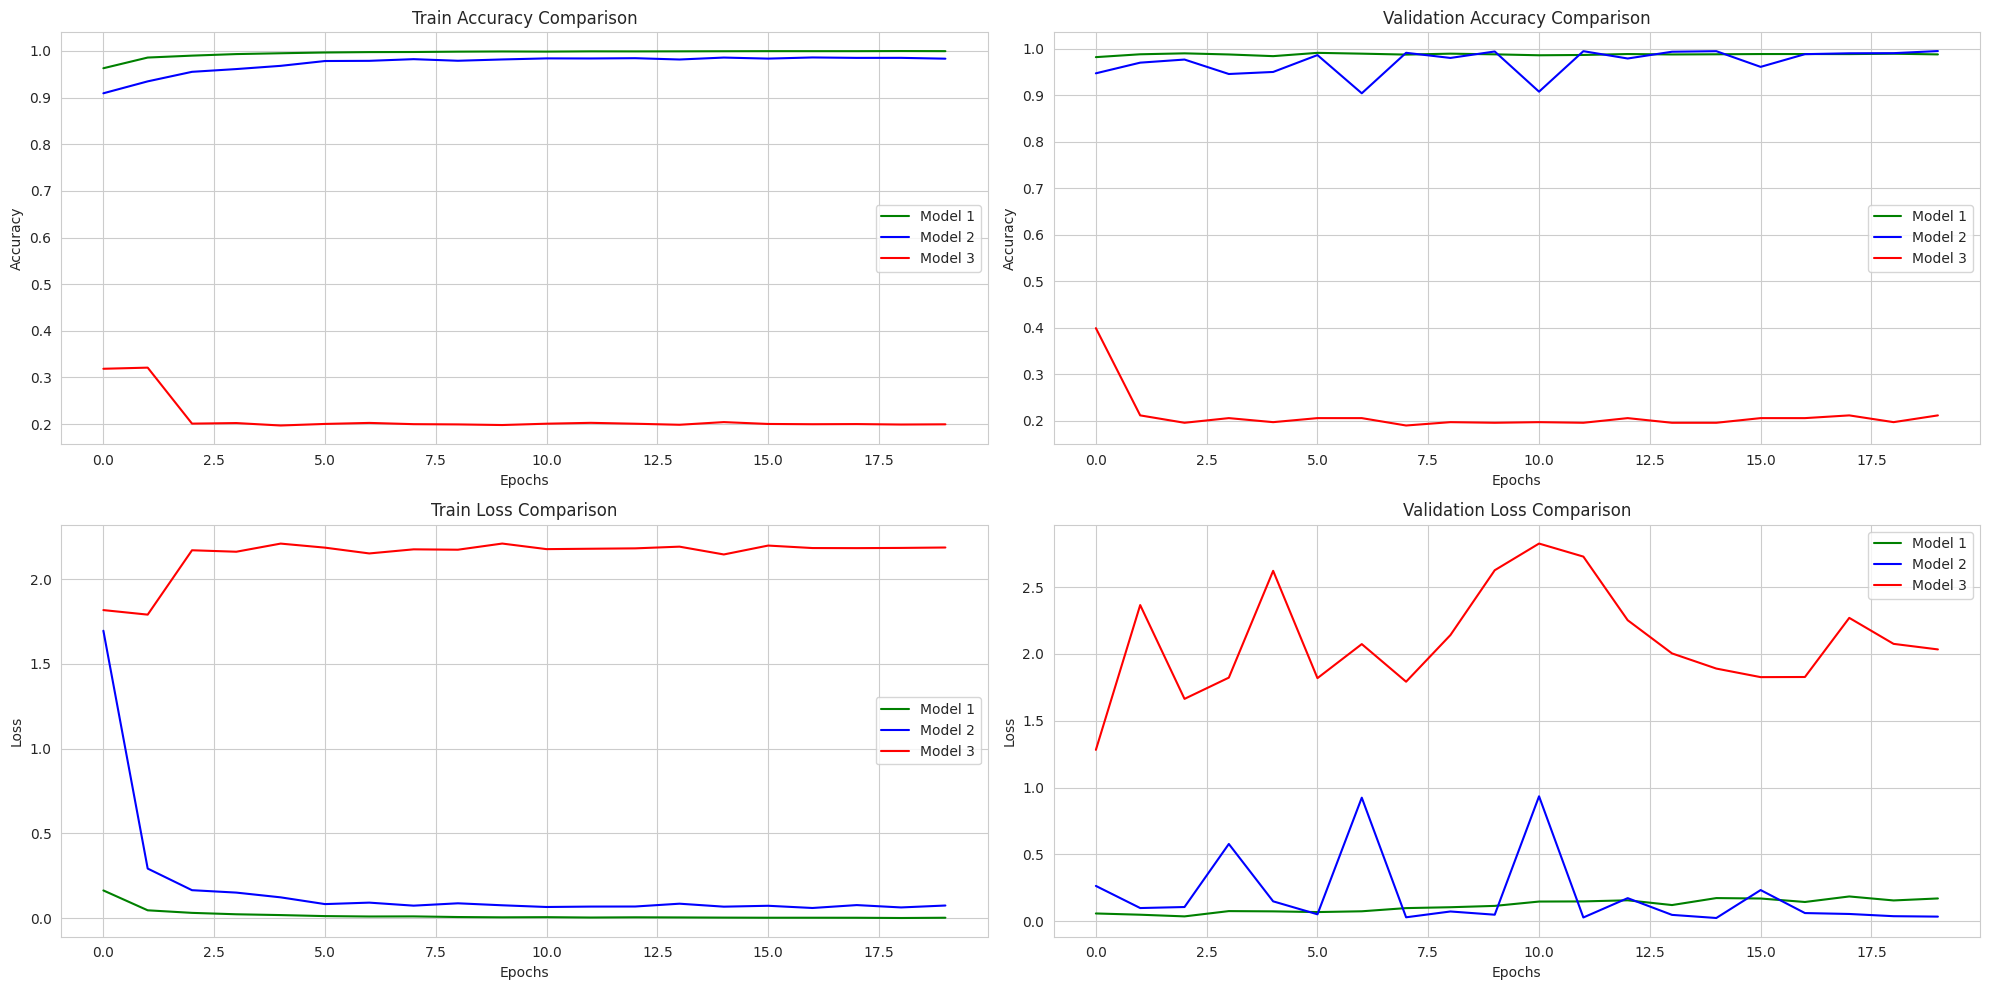

In [56]:
result(model1, history_model1, model2, history_model2, model3, history_model3)